#  Where (not) to eat in Chicago? Project milestone 3


In [1]:
data_folder = "data"
MAPBOX_ACCESS_TOKEN = 'pk.eyJ1IjoiYnpkZWNvIiwiYSI6ImNrNDVmNTU5ZTA1dnIzZXJ2Zm9vbmZsd2EifQ.KvNq66ornrV9ACa98F0s9w'

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [3]:
import json

import shapely
from shapely.geometry import shape, Point

In [4]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go

Our wrapper funcitons for plotting maps using plotly:

In [5]:
import copy
import os
import re
import json
import pandas as pd
import numpy as np
import plotly.graph_objects as go

def insert_variables_as_properties_in_geodata(geodata, dataframe, key_property, key_column, variable_names):
    output_geodata = copy.deepcopy(geodata)
    
    for feature in output_geodata['features']:
        key = feature['properties'][key_property]
        row = dataframe[dataframe[key_column] == key]

        if not row.empty:
            variables_values = row[variable_names].values[0]
            for name, value in zip(variable_names, variables_values):
                feature['properties'][name] = str(value)
    
    return output_geodata

def format_template(template, variable_names):
    replaced = copy.deepcopy(template)
    for name in variable_names:
        replaced = re.sub(r'\{\}', '%{properties.' + name + '}', replaced, count=1)
    return replaced

def load_geodata(geodata_path, key_property):
    with open(os.path.join(geodata_path)) as geojson_file:
        geodata = json.loads(geojson_file.read())
        # add id feature for choroplethmapbox
        for feature in geodata['features']:
            feature['id'] = feature['properties'][key_property]
        return geodata

def plot_map(title, geodata_path, dataframe, key_property, key_column, value_column, template, mapbox_access_token, options):
    '''
    title: plot title
    
    geodata_path: path to the geojson file
    
    dataframe: Dataframe with columns: 
      - key (column name specified in key_column),
      - value plotted as color of the neighborhood (column name specified in value_column)
      - any other values in additional columnss will be used as an variables interpolated into the template
    
    key_property: value distinguishing each area in the geojson file stored in properties section

    key_column: name of the column in the dataframe containing key values (distinguishing areas)
    
    value_column: name of the column in the dataframe containig values for filling neighborhoods with colors
    template: text that will be displayed in a box over the hovered neighborhood. Any variable in the template
    should be denoted by "{}". Variables will be taken from the remaining columns of the dataframe in the order
    in which the columns appear.
    
    template: a string in a python string format (with {} in places where to put variables)
    
    mapbox_access_token: token needed for using mapbox

    options: options styling the plot
    '''
    # unpack options
    colorscale = options['colorscale'] if 'colorscale' in options else 'Viridis'
    colorbar = options['colorbar'] if 'colorbar' in options else {}
    showscale = options['showscale'] if 'showscale' in options else True
    
    # load geodata
    geodata = load_geodata(geodata_path, key_property)
    
    # prepare data
    columns = dataframe.columns.values
    dropped_columns = set([key_column, value_column])
    variable_names = [column for column in columns if column not in dropped_columns]
    extended_geodata = insert_variables_as_properties_in_geodata(geodata, dataframe, key_property, key_column, variable_names)
    formatted_template = format_template(template, variable_names) + '<extra></extra>'
    
    # plot
    figure = go.Figure(go.Choroplethmapbox(
        geojson=extended_geodata,
        locations=dataframe[key_column],
        z=dataframe[value_column],
        hovertemplate=formatted_template,
        showscale=showscale,
        colorscale=colorscale,
        colorbar=colorbar
    ))
    figure.update_layout(
        title=title,
        font={'family': 'Arial Black'},
        mapbox_accesstoken=mapbox_access_token,
        mapbox_zoom=9,
        mapbox_pitch=0,
        mapbox_bearing=0,
        mapbox_center={'lat': 41.86, 'lon': -87.63},
        margin={'r': 0, 'l': 50, 't': 50, 'b': 0}
    )
    return figure

class MapLayer():
    def __init__(self, name, dataframe, key_column, value_column, options):
        self.name = name
        self.dataframe = dataframe
        self.key_column = key_column
        self.value_column = value_column
        self.options = options

# Implementation based on: https://plot.ly/~empet/15237/choroplethmapbox-with-dropdown-menu/#/
def plot_maps(title, geodata_path, key_property, layers, template, mapbox_access_token, options):    
    # load geodata
    geodata = load_geodata(geodata_path, key_property)
    
    data = []
    for layer in layers:
        # extract variables
        dataframe = layer.dataframe
        key_column = layer.key_column
        value_column = layer.value_column
        # unpack options
        colorscale = layer.options['colorscale'] if 'colorscale' in options else 'Viridis'
        colorbar = layer.options['colorbar'] if 'colorbar' in options else {}
        showscale = layer.options['showscale'] if 'showscale' in options else True
        
        # prepare data
        columns = dataframe.columns.values
        dropped_columns = set([key_column, value_column])
        variable_names = [column for column in columns if column not in dropped_columns]
        extended_geodata = insert_variables_as_properties_in_geodata(geodata, dataframe, key_property, key_column, variable_names)
        formatted_template = format_template(template, variable_names) + '<extra></extra>'
    
        # plot
        figure = go.Figure()
        data.append(go.Choroplethmapbox(
            geojson=extended_geodata,
            locations=dataframe[key_column],
            z=dataframe[value_column],
            hovertemplate=formatted_template,
            showscale=showscale,
            colorscale=colorscale,
            colorbar=colorbar,
            visible=False
        ))
    
    # mark first layer as visible
    data[0]['visible'] = True
    
    # create layout
    layout = go.Layout(
        title=title,
        font={'family': 'Arial Black'},
        mapbox_accesstoken=mapbox_access_token,
        mapbox_zoom=9,
        mapbox_pitch=0,
        mapbox_bearing=0,
        mapbox_center={'lat': 41.86, 'lon': -87.63},
        margin={'r': 0, 'l': 50, 't': 50, 'b': 0}
        
    )
    
    # create layers visibility lists
    visibilities = []
    template_visibility = np.zeros((len(layers),)).astype(bool)
    for i in range(len(layers)):
        visibility = list(np.copy(template_visibility))
        visibility[i] = True
        visibilities.append(visibility)
    
    # create menu buttons
    buttons = []
    for i, layer in enumerate(layers):
        buttons.append({
            'args': ['visible', visibilities[i]],
            'label': layer.name,
            'method': 'restyle'
        })
    
    # update layout adding menu
    layout.update(
        updatemenus=[{
            'x': 0.95,
            'y': 0.95,
            'yanchor': 'top',
            'buttons': buttons
        }]
    )
    
    figure = go.Figure(data=data, layout=layout)
    return figure

In [6]:
# Function for saving plots as html and loading them
from plotly.offline import plot
from IPython.display import IFrame

def plot_offline(fig,filename):
    #filename = "inspections_per_year.html"
    html = plot(fig, auto_open=False, output_type='div')
    with open(filename, 'w') as file:
        file.write(html)
    pyo.plot(fig, filename=filename,validate=False)
    return IFrame(src=filename, width=1000, height=600)

We start by reading our data

In [7]:
inspections = pd.read_csv(os.path.join(data_folder, "food-inspections.csv"))

We can now look into the fetures and types of our dataset through a sample :

In [8]:
inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,2345969,LORDANCHILD CHRISTIAN DAY CARE INC.,LORDANCHILD CHRISTIAN DAY CARE INC.,2215931.0,Children's Services Facility,Risk 1 (High),3344 W 79TH ST,CHICAGO,IL,60652.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.749915,-87.706628,"{'longitude': '41.749914910076974', 'latitude'...",NaN,NaN,NaN,NaN,NaN
1,2345986,TACOS & SALSAS LLC,TACOS & SALSAS,2684121.0,Mobile Food Preparer,Risk 2 (Medium),2300 S THROOP ST,CHICAGO,IL,60608.0,...,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.850451,-87.658798,"{'longitude': '41.85045102427', 'latitude': '-...",NaN,NaN,NaN,NaN,NaN
2,2345977,"KIMBALL DAY CARE CENTER & KINDERGARTEN , INC.","KIMBALL DAY CARE CENTER & KINDERGARTEN , INC.",2215859.0,Daycare (2 - 6 Years),Risk 1 (High),1636 N KIMBALL AVE,CHICAGO,IL,60647.0,...,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.911155,-87.711859,"{'longitude': '41.911154536126396', 'latitude'...",NaN,NaN,NaN,NaN,NaN
3,2345959,DUNKIN DONUTS,DUNKIN DONUTS,1803815.0,Restaurant,Risk 2 (Medium),4453 S ARCHER AVE,CHICAGO,IL,60632.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.812307,-87.706919,"{'longitude': '41.81230749019629', 'latitude':...",NaN,NaN,NaN,NaN,NaN
4,2345967,SHEEBA MEAT & GROCERY,SHEEBA MEAT & GROCERY,2699426.0,Grocery Store,Risk 2 (Medium),4307 W LAWRENCE AVE,CHICAGO,IL,60630.0,...,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968045,-87.735750,"{'longitude': '41.96804517534159', 'latitude':...",NaN,NaN,NaN,NaN,NaN


In [9]:
inspections.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Results', 'Violations', 'Latitude', 'Longitude',
       'Location', 'Historical Wards 2003-2015', 'Zip Codes',
       'Community Areas', 'Census Tracts', 'Wards'],
      dtype='object')

First thing we notice is the strange presence of the columns Historical Wards 2003-2015, Zip Codes, Community Areas, Census Tracts and Wards. These columns all have only NaN values, so we are dropping them:

In [10]:
inspections.drop(columns=['Historical Wards 2003-2015', 'Zip Codes',
       'Community Areas', 'Census Tracts', 'Wards'],inplace=True)

Let's see what are the possible categories of our facilities:

In [11]:
inspections["Facility Type"].unique()

array(["Children's Services Facility", 'Mobile Food Preparer',
       'Daycare (2 - 6 Years)', 'Restaurant', 'Grocery Store',
       'Daycare Above and Under 2 Years', nan, 'Bakery', 'School',
       'PALETERIA', 'Long Term Care', 'HERBALIFE', 'Catering',
       '15 monts to 5 years old', 'BANQUET', 'MOBILE FOOD',
       'GAS STATION/GROCERY', 'CUSTOM POULTRY SLAUGHTER', 'COFFEE SHOP',
       'HOSTEL', 'Liquor', 'Pop-Up Food Establishment User-Tier II',
       'VENDING COMMISSARY', 'LIVE POULTRY', 'Daycare (Under 2 Years)',
       'Hospital', 'ICE CREAM', 'Pop-Up Establishment Host-Tier II',
       'CHARTER SCHOOL', 'tavern', 'Mobile Food Dispenser',
       'CHILDRENS SERVICES FACILITY', 'BREWERY', 'RESTAURANT/BAR', 'GYM',
       'TAVERN', "CHILDERN'S SERVICE FACILITY", 'Golden Diner',
       'GROCERY STORE /PHARMACY', 'Daycare Combo 1586', 'ASSISTED LIVING',
       'Airport Lounge', "1023 CHILDREN'S SERVICES FACILITY",
       'PRIVATE SCHOOL', 'EXERCISE AND NUTRITION BAR', 'COOKING SC

We can notice very different facility types; as we want to analyze only restaurants we will keep only entries where "Restaurant" is the Facility Type. Let's see if we have any entries with missing Facility Type:

In [12]:
print("There are {0} missing values for Facility Type in the dataset".format(inspections['Facility Type'].isna().sum()))

There are 4775 missing values for Facility Type in the dataset


For now we will get rid of those rows as they are of no use to us:

In [13]:
inspections = inspections.dropna(subset=["Facility Type"])

We only want to analyze entries which correspond to restaurants so we will keep only those rows

In [14]:
# Keep only restaurants for the rest of the analysis
inspections = inspections[inspections["Facility Type"].str.contains("restaurant", case=False)]

In [15]:
print(f"We have {len(inspections)} rows in our dataset, each row corresponds to one inspection")

We have 131063 rows in our dataset, each row corresponds to one inspection


Since we are going to compare inspection's results over time, let's look at the time range we have for the inspections.

In [16]:
# Cast Inspection Date to Datetime type
inspections['Inspection Date'] = pd.to_datetime(inspections['Inspection Date'])

In [17]:
print('The first inspection in the dataset happened in {0}, and the last one happened was on {1}'. 
      format(inspections['Inspection Date'].min().strftime("%d.%m.%Y"), inspections['Inspection Date'].max().strftime("%d.%m.%Y.")))

The first inspection in the dataset happened in 04.01.2010, and the last one happened was on 20.11.2019.


## Data preprocessing

We will now proceed with preparing the dataset for the analysis. Below we take the following preprocessing steps:
1. Making Licence # column a unique identifier of restaurants in the dataset.
2. Fixing the zip codes by completing the missing values based on the values of Longitude and Latitude.
3. Fixing the City column by completing the missing values based on the zip code.
4. Standardizing the Inspection Type values by cleaning various namings and reducing the number of categories.

### Making unique licenses

The original dataset we have is inspections-oriented, but our analysis will be mainly focused on restaurants. That is why we need a feature which will help us uniquely identify each restaurant.

In [18]:
print(f"Using DBA Name we can see there are {inspections['DBA Name'].nunique()} distinct restaurant names")

Using DBA Name we can see there are 14213 distinct restaurant names


In [19]:
print(f"Using restaurant Licenses we can see there are {inspections['License #'].nunique()} distinct restaurants")

Using restaurant Licenses we can see there are 19995 distinct restaurants


We have probably many non unique names due to restaurants such as McDonalds and other large food-serving chains. We want to make the license number our primary key for restaurant identification as we assume different restaurants have different license numbers. First, let's check if there are any missing values in this column:

In [20]:
print(f"There are {inspections['License #'].isna().sum()} restaurant that have NaN licence number")

There are 0 restaurant that have NaN licence number


We noticed however that there are some restaurant with licence numbers equal to 0, let's see how many there are:

In [21]:
print(f"There are {len(inspections[inspections['License #'] == 0.0])} restaurant that have zero licence number")

There are 114 restaurant that have zero licence number


As we can see, there is no column that can help us uniquely identify a restaurant. The closest match is License # feature, which has some restaurants with 0 assigned as their license number. We decided to add fake licence numbers and use it as a restaurant identifier later on.

In [22]:
# Get entries where License number is missing
zero_license = inspections[inspections["License #"] == 0.0]

In [23]:
zero_license.nunique()

Inspection ID      114
DBA Name            63
AKA Name            50
License #            1
Facility Type        3
Risk                 3
Address             63
City                 2
State                1
Zip                 33
Inspection Date    108
Inspection Type      9
Results              6
Violations          74
Latitude            62
Longitude           62
Location            62
dtype: int64

To be able to identify restaurants with license number equal to 0, we will use restaurant location and name. Using this two attributes, we can create artificial license numbers for restaurants with missing license numbers:

In [24]:
# Get the maximum license number that exists in the database and use it as starting point for the newly generated license numbers
start_id = int(inspections["License #"].max() + 1)
missing_licenses = inspections[(inspections["License #"] == 0)][["DBA Name","Location"]].copy().drop_duplicates()
missing_licenses["new License"] = [i for i in range(start_id, start_id+len(missing_licenses.drop_duplicates()))]

In [25]:
# Merge dataset
inspections = inspections.merge(missing_licenses, on=["DBA Name","Location"], how='left')

In [26]:
# Populate missing licence numbers with newly generated license numbers
inspections["License #"] = inspections["License #"].apply(lambda x: np.nan if x == 0 else x)
inspections["License #"] = inspections["License #"].fillna(value = inspections["new License"])
inspections.drop(columns=["new License"], inplace=True)

In [27]:
print("There are {0} missing license numbers in our dataset".format(inspections[inspections["License #"] == 0].size))

There are 0 missing license numbers in our dataset


In [28]:
# Cast License number from float to int
inspections["License #"] = inspections["License #"].apply(lambda x : int(x))

### Completing zip codes based on geographical coordinates

We want to populate the missing Zip values based on the Latitude and Longitude. In order to do that, we must have those two features for all the restaurants in the dataset. That is why we decided to drop all entries where one of those features is missing.

In [29]:
inspections = inspections[~((inspections['Longitude'].isna()) | (inspections['Latitude'].isna()))]

In [30]:
print('There are {0} missing values for Zip column'.format(inspections[inspections['Zip'].isna()].shape[0]))
print('There are {0} missing values for City column'.format(inspections[inspections['City'].isna()].shape[0]))

There are 20 missing values for Zip column
There are 69 missing values for City column


In [31]:
restaurants_zip_na = inspections[inspections['Zip'].isna()]

To populate Zip values based on coordinates, we use [shapely](https://pypi.org/project/Shapely/) - Python package for manipulation and analysis of planar geometric objects.

In [32]:
# Function that creates points from Latitude and Longitude
def create_points(df):
    coords = list(zip(df['Longitude'], df['Latitude']))
    res = []
    for coord in coords:
        res.append(shapely.geometry.Point(coord))
    return res

In [33]:
# Create list of points for which we want to get Zip code
points = create_points(restaurants_zip_na)

In [34]:
# Method which checks whether the points are in area described in geojson file and returns data with zip value for found points
def populate_missing_zip(points, geojson_filename):
    # load GeoJSON file containing sectors
    state_geo_path = r'{0}'.format(geojson_filename)
    geo_json_data = json.load(open(state_geo_path))

    zip_found = []
    # check each polygon to see if it contains the point
    for feature in geo_json_data['features']:
        polygon = shapely.geometry.shape(feature['geometry'])
        for point in points: 
            if polygon.contains(point):
                point_complete = {'Longitude':point.x, 'Latitude':point.y, 'Zip':feature.get('properties', {}).get('zip')}
                zip_found.append(point_complete)
    return zip_found

In [35]:
# Find missing Zip values
zip_found = populate_missing_zip(points, os.path.join(data_folder, 'chicago-zip.json'))
print('Total {0} point found matching Chicago sectors.'.format(len(zip_found)))

Total 20 point found matching Chicago sectors.


In [36]:
zip_found = pd.DataFrame(zip_found)
zip_found.head()

,Longitude,Latitude,Zip
0,-87.673459,42.019032,60626
1,-87.673459,42.019032,60626
2,-87.673459,42.019032,60626
3,-87.659816,41.968491,60640
4,-87.659816,41.968491,60640


Now, we have to merge those results with the original dataset.

In [37]:
# Before merging, drop duplicate points
zip_found.drop_duplicates(inplace=True)

In [38]:
inspections = inspections.merge(zip_found,on=['Latitude','Longitude'], how='left',suffixes=('', '_notnull'))
inspections.Zip.fillna(value=inspections.Zip_notnull, inplace=True)
inspections.drop(columns=["Zip_notnull"], inplace=True)

In [39]:
print('There are {0} missing Zip left in the restaurant dataset.'.format(inspections[inspections.Zip.isnull()].shape[0]))

There are 0 missing Zip left in the restaurant dataset.


In [40]:
# Change type of Zip feature from float to string
inspections['Zip']=inspections['Zip'].apply(lambda x: str(int(x)))

### Completing City column based on zip codes

We will also fix the City column. Now we can use the Zip column to fill in the missing information about the city.

In [41]:
# Function that returns all Chicago Zips frem geojson file
def create_chicago_zip_list():
    state_geo_path = os.path.join(data_folder, "chicago-zip.json")
    geo_json_data = json.load(open(state_geo_path))

    zips = []
   
    for feature in geo_json_data['features']:
        zips.append(str(feature.get('properties', {}).get('zip')))
    return set(zips)

In [42]:
# Get list of all Zip codes in Chicago
chicago_zip = create_chicago_zip_list()

In [43]:
# Check if there is any restaurant not in Chicago
not_in_chicago = len(inspections[inspections.City.isna() & (~inspections.Zip.isin(chicago_zip))])
print('There are {0} Zip values which are not in Chicago.'.format(not_in_chicago))

There are 0 Zip values which are not in Chicago.


In [44]:
# Replace all City missing values with Chicago
inspections.City.fillna(value='Chicago', inplace=True)

In [45]:
print('There are {0} missing City values left in the restaurant dataset.'.format(inspections[inspections.City.isnull()].shape[0]))

There are 0 missing City values left in the restaurant dataset.


In [46]:
inspections.City.unique()

array(['CHICAGO', 'Chicago', 'CCHICAGO', 'CHICAGO.', 'CHICAGOHICAGO',
       'chicago', 'CHICAGOCHICAGO', '312CHICAGO', 'CHICAGOI'],
      dtype=object)

In [47]:
# Change all values for City column to be Chicago
inspections.City = 'Chicago'
inspections.City.unique()

array(['Chicago'], dtype=object)

### Standardizing/cleaning Inspection Type values

In [48]:
inspections['Inspection Type'].unique()

array(['Canvass', 'Complaint', 'Canvass Re-Inspection',
       'Short Form Complaint', 'License', 'License Re-Inspection',
       'Suspected Food Poisoning', 'Complaint Re-Inspection',
       'Recent Inspection', 'Suspected Food Poisoning Re-inspection',
       'Consultation', 'Non-Inspection', 'Recent inspection',
       'fire complaint', 'FIRE', 'Tag Removal', nan, 'Not Ready',
       'License-Task Force', 'Complaint-Fire Re-inspection',
       'Complaint-Fire', 'Short Form Fire-Complaint',
       'KITCHEN CLOSED FOR RENOVATION', 'CORRECTIVE ACTION',
       'LICENSE CANCELED BY OWNER', 'Task Force Liquor 1475',
       'TWO PEOPLE ATE AND GOT SICK.', 'Pre-License Consultation',
       'CANVASS SPECIAL EVENTS', 'OUT OF BUSINESS', 'No entry',
       'NO ENTRY', 'Package Liquor 1474', 'Sample Collection',
       'FIRE/COMPLAIN', '1315 license reinspection',
       'Task Force Liquor Catering', 'SFP', 'CANVAS', 'no entry',
       'SFP/COMPLAINT', 'SFP/Complaint', 'Special Events (Festival

Looking at `Inspection Type` values we can see that they need some cleaning. According to the [document describing the dataset](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) we should have following inspection types:
 - **canvass**: regular inspections with frequency depending on establishment risk,
 - **complaint**: in a response to filed complaint,
 - **license**: when obtaining a license, as a requirement of launching the establishment (should be once for most or more if they failed, this might be a separate study case),
 - **suspect food poisoning**: specific type of *complaint* when someone reports getting ill after eating from there
 - **task-force**: for bars and taverns.

Also, as the linked document states, re-inspections can be done for most of the types and are indicated in the name of inspection type.

First, we replace NaN values in Inspection Type with "Unknown":

In [49]:
inspections.fillna(value={'Inspection Type': 'Unknown'}, inplace=True)

Now, since we may want to use the indication whether a particular inspection was a re-inspection or not, we add a separate column that will indicate that:

In [50]:
reinspection_pattern = 're-inspec|reinspec|re inspec'
inspections['Re-inspection'] = inspections['Inspection Type'].str.lower().str.contains(reinspection_pattern, regex=True)

Now, we proceed with making the names for given types of inspections uniform:

In [51]:
inspection_types = inspections['Inspection Type'].unique().astype(str)
inspection_types_lower = np.char.lower(inspection_types)

In [52]:
# Replaces values in Inspection Type for records with keywords found in them with the specified replacement value
def standardize_by_finding_keyword(keywords, replacement):
  to_replace = np.array([])
  for keyword in keywords:
    to_replace = np.append(to_replace, inspection_types[np.char.find(inspection_types_lower, keyword) != -1])
  inspections['Inspection Type'] = inspections['Inspection Type'].replace(to_replace, value=replacement)

In [53]:
standardize_by_finding_keyword(['canvas'], 'Canvass')
standardize_by_finding_keyword(['complain'], 'Complaint')
standardize_by_finding_keyword(['license'], 'License')
standardize_by_finding_keyword(['task', 'liquor'], 'Task Force')

In [54]:
# Suspected Food Poisoning replacements
sfp_values = inspections['Inspection Type'].str.lower().str.contains('food|sfp', regex=True)
inspections.loc[sfp_values, 'Inspection Type'] = 'Suspected Food Poisoning'
standardize_by_finding_keyword(['sick'], 'Suspected Food Poisoning')

In [55]:
inspections.groupby(by='Inspection Type')['Inspection ID'].count()

Inspection Type
CHANGED COURT DATE                   1
CORRECTIVE ACTION                    1
Canvass                          83883
Complaint                        25100
Consultation                       396
FIRE                                 1
HACCP QUESTIONAIRE                   1
KITCHEN CLOSED FOR RENOVATION        1
License                          19483
NO ENTRY                             5
No Entry                            48
No entry                             1
Non-Inspection                       9
Not Ready                            7
OUT OF BUSINESS                     11
Out of Business                     53
POSSIBLE FBI                         1
RE-INSPECTION OF CLOSE-UP            1
REINSPECTION                         1
Recent Inspection                  229
Recent inspection                    1
Sample Collection                    1
Special Events (Festivals)          21
Suspected Food Poisoning           919
TASTE OF CHICAGO                     1
Tag Remov

There are still a lot of values that appear only once in the entire dataset. There are also ones that could be merged into single categories (e.g. "no entry", "out of business", "recent inspection"). We also decide to leave the categories with significant amount of records, such as "Consultation". The ones we decide to drop will be reclassified under "Unknown" category.

In [56]:
# Replaces records with keyword found in category name to be classified in a given target category
def merge_categories(keyword, target_category):
  categories_containing_keyword = inspections['Inspection Type'].str.lower().str.contains(keyword)
  inspections.loc[categories_containing_keyword, 'Inspection Type'] = target_category  

In [57]:
merge_categories('recent inspection', 'Recent Inspection')
merge_categories('out of business', 'Out of Business')
merge_categories('no entry', 'No Entry')

In [58]:
known_list = ['License', 'Canvass', 'Complaint', 'Consultation', 'No Entry', 'Out of Business', 'Recent Inspection', 'Suspected Food Poisoning', 'Tag Removal', 'Task Force']
# Classify the rest as unknown
inspections.loc[~inspections['Inspection Type'].isin(known_list), 'Inspection Type'] = 'Unknown'

In [59]:
inspections.groupby(by='Inspection Type')['Inspection ID'].count()

Inspection Type
Canvass                     83883
Complaint                   25100
Consultation                  396
License                     19483
No Entry                       56
Out of Business                64
Recent Inspection             230
Suspected Food Poisoning      919
Tag Removal                   483
Task Force                    225
Unknown                        51
Name: Inspection ID, dtype: int64

Additionally, let's propagate "Out of Business" indication to "Results" column where it should be indicated:

In [60]:
out_of_business = inspections[inspections['Inspection Type'] == 'Out of Business'].index
inspections.loc[out_of_business, 'Results'] = 'Out of Business'

## Features extraction

For the research questions we want to explore, we needed to create following additional columns in the dataset:

1. **Community and District** - those columns are more meaningful than Zip code and will help us interpret the results in more natural and significant way
2. **Violation Codes** - for every inspection, based on Violations we want to extract codes of violations found during inspection
3. **Generalized Violation Codes** - we want to classify all violations into smaller number of categories based on the general meaning they carry
4. **Critical Violation and Serious Violation** - for every inspection, we want to know if any critical or serious violation was made during that inspection

### Creating Community and District Column

Chicago is divided into 77 Community Areas that can also be grouped into 9 Districts. Even though we have Zip codes for each restaurant, the role of Zip codes in real world is mainly related to post office and delivery services. People who live in Chicago and visit Chicago are, however, using Community Areas and districts for orientation. 

We decided to enrich the dataset with this information. We are using the `chicago-community-areas` geojson file for getting boundaries of community areas, and shapely library to check for each coordinate in which community area it belongs (same approach that we used for populating missing Zip codes).

In [61]:
# Extract unique Latitude and Longitude from inspections
unique_coords = inspections.copy()[['Latitude','Longitude']].drop_duplicates()

# Create shapely points
points = create_points(unique_coords)

In [62]:
# Method which checks whether the points are in area described in geojson file and returns data with community area name for found points
def populate_area(points, geojson_filename):
    # load GeoJSON file containing sectors
    state_geo_path = r'{0}'.format(geojson_filename)
    geo_json_data = json.load(open(state_geo_path))

    area_found = []
    # check each polygon to see if it contains the point
    for feature in geo_json_data['features']:
        polygon = shapely.geometry.shape(feature['geometry'])
        for point in points: 
            if polygon.contains(point):
                point_complete = {'Longitude':point.x, 'Latitude':point.y, 'Community':feature.get('properties', {}).get('community')}
                area_found.append(point_complete)
    return area_found

In [63]:
area_found = populate_area(points, os.path.join(data_folder, 'chicago-community-boundaries.json'))
print('Total {0} point found matching Chicago sectors.'.format(len(area_found)))

Total 9437 point found matching Chicago sectors.


In [64]:
area_found = pd.DataFrame(area_found)
inspections = inspections.merge(area_found,on=['Latitude','Longitude'], how='left')
print('There are {0} missing Community left in the restaurant dataset.'.format(inspections[inspections.Community.isnull()].shape[0]))

There are 2502 missing Community left in the restaurant dataset.


Since we have some missing values after populating the Community values from geojson, we will try to fix them manually. Let's see if there is some pattern in the missing data.

In [65]:
inspections[inspections.Community.isna()].Zip.unique()

array(['60666', '60611'], dtype=object)

It seems that the only missing data are from two Zip codes. By doing quick google search and looking at maps, we can see that 60666 refers to O'Hare International Airport and 60611 is Near North Side.

In [66]:
# Populate missing values
inspections.loc[((inspections.Community.isna()) & (inspections.Zip == '60666')), 'Community'] = "O'HARE INTERNATIONAL AIRPORT"
inspections.loc[((inspections.Community.isna()) & (inspections.Zip == '60611')), 'Community'] = "NEAR NORTH SIDE"

print('There are {0} missing Community left in the restaurant dataset.'.format(inspections[inspections.Community.isna()].shape[0]))

There are 0 missing Community left in the restaurant dataset.


In [67]:
inspections.Community.unique()

array(['BRIGHTON PARK', 'DUNNING', 'WEST TOWN', 'NORTH PARK',
       "O'HARE INTERNATIONAL AIRPORT", 'LOGAN SQUARE', 'AUBURN GRESHAM',
       'ROGERS PARK', 'BELMONT CRAGIN', 'AUSTIN', 'SOUTH LAWNDALE',
       'GARFIELD RIDGE', 'MONTCLARE', 'WEST ELSDON', 'LINCOLN PARK',
       'NORWOOD PARK', 'EAST SIDE', 'LAKE VIEW', 'LINCOLN SQUARE',
       'ALBANY PARK', 'NEAR NORTH SIDE', 'WEST LAWN', 'WEST RIDGE',
       'IRVING PARK', 'BRIDGEPORT', 'HUMBOLDT PARK', 'GAGE PARK',
       'NEAR WEST SIDE', 'LOOP', 'BEVERLY', 'AVONDALE', 'JEFFERSON PARK',
       'LOWER WEST SIDE', 'HERMOSA', 'PORTAGE PARK', 'UPTOWN',
       'ARCHER HEIGHTS', 'MCKINLEY PARK', 'ASHBURN', 'NORTH LAWNDALE',
       'ARMOUR SQUARE', 'GREATER GRAND CROSSING', 'EDGEWATER',
       'FOREST GLEN', 'WOODLAWN', 'CLEARING', 'SOUTH CHICAGO',
       'NORTH CENTER', 'DOUGLAS', 'HYDE PARK', 'ENGLEWOOD', 'MORGAN PARK',
       'ROSELAND', 'WEST PULLMAN', 'NEAR SOUTH SIDE', 'CHATHAM',
       'NEW CITY', 'MOUNT GREENWOOD', 'SOUTH SHORE', 

We are also going to get the information about Districts for each restaurant. For that we created a mapping between Communities and Districts ([source](http://www.thechicago77.com/chicago-neighborhoods/)), which we load from csv file.

In [68]:
chicago_communities = pd.read_excel(os.path.join(data_folder, 'Chicago-Communities.xlsx'))
chicago_communities.head()

,Community,District
0,Rogers Park,Far North Side
1,West Ridge,Far North Side
2,Uptown,Far North Side
3,Lincoln Square,Far North Side
4,Edison Park,Far North Side


In [69]:
chicago_communities.Community = chicago_communities.Community.apply(lambda x: str.upper(x).strip())

In [70]:
inspections =inspections.merge(chicago_communities, on='Community', how='left')
print('There are {0} missing District left in the restaurant dataset.'.format(inspections[inspections.District.isna()].shape[0]))

There are 0 missing District left in the restaurant dataset.


Since our main motivation to get Community Areas and District for the inspections and restaurants is to be able to create map for visualizing results, we also needed the geojson file with district boundaries. Since we couldn't find it online, we created it on our own using the `chicago-community-areas` geojson file and by making unions of ares that belong to the same district. The source code for that can be found in `notebooks\creating_district_boundaries.ipynb`.

### Extracting Violation Codes

In our dataset violations detected during the inspections are noted in the Violations column. Each violation contains a code, general violation description (name/category of the violation) and comments added by the inspector. Since the violation codes uniquely identify a particular violation, we extract them and use them for our analysis.


In [71]:
print('There are {0} missing values in the Violations column'.format(inspections['Violations'].isna().sum()))

There are 31837 missing values in the Violations column


In [72]:
inspections.fillna(value={'Violations': ''}, inplace=True)

In [73]:
# Extract violation codes from textual list of violations
def extract_violation_codes(violation):
    violations_list = list(map(lambda v: v.strip(), violation.split('|')))
    violation_dots = [violation.find('.') for violation in violations_list]
    # using set to get rid of multiple same category violations per inspection (to not disturb the distributions)
    violation_codes = list(set([int(v[:idx]) for v, idx in zip(violations_list, violation_dots) if idx != -1]))
    return violation_codes

In [74]:
# Add additional column with extracted codes
inspections['Violation Codes'] = inspections['Violations'].apply(extract_violation_codes)

### Creating Generalized Violation Codes

What we also want to do in this part is categorize these violation reasons into bigger, more general groups. Categorizing violations into smaller number of groups would help us understand the highlevel reasons for failing the inspection better and would also help in creating visualizations easier to understand. That is why we manually grouped all violation codes into **5 categories** (using the violation descriptions for understanding what each violation code means):
1. **Food violations:** in this category we put all of the violations which are related to the food and ingredients: the way they are obtained, stored, transported, prepared, labeled etc.
2. **Facility conditions related violations:** presence of appropriatelly set up equipment and utilities (freezer, owens, work surface etc.), as well as requirements for the building and infrastructure (lighting, ventilation, temperature, pipes, walls etc.).
3. **Sanitary related violations:** violations that are related to keeping all the equipment, rooms and surfaces clean .
4. **Staff related violations:** violations related to the employees (necesarry trainings, the way they work with food, manager's work etc.).
5. **Other:** the violations that did not match the previous groups (eg. summary report of the inspection visible to the public, no smoking regulations etc.).

What is really important for us is that, as indicated in the [linked document](http://dev.cityofchicago.org/open%20data/data%20portal/2018/06/29/food-violations-changes.html) from the dataset page, the violation codes and descriptions have changed as of 1/07/2018. This means, that violation codes before and after this date don't correspond to the same violation reason. We first tried to map the changed values to the old ones, but it did not give results we expected (there are many new violations added and also the meaning of many violation changed). Therefore we'll usually need to split our analysis into two parts, so that violation codes in each part are consistent - analyze the inspections before 1/07/2018 and after this day. This is where general categorization will be useful because it will allow us to connect those two periods because we keep same 5 categories for all violations.

In [75]:
# Split the dataset regarding the change of violation definitions
violation_change_date = pd.Timestamp(year=2018, month=7, day=1)
inspections['Inspection Date'] = pd.to_datetime(inspections['Inspection Date'])
inspections_before_change = inspections[inspections['Inspection Date'] < violation_change_date]
inspections_after_change = inspections[inspections['Inspection Date'] >= violation_change_date]

In [76]:
# Custom grouping in categories for violations before change
food_codes_before = [1, 3, 15, 16, 17, 30]
facility_codes_before = [2, 7, 9, 11, 13, 18, 22, 23, 24, 25, 26, 29, 32, 35, 36, 37, 38, 40, 42, 43]
sanitary_codes_before = [4, 8, 10, 12, 19, 20, 27, 31, 33, 34, 39, 41]
staff_codes_before = [5, 6, 21, 44, 45]
unknown_codes_before = [14, 28, 70]

codes_before = [food_codes_before, facility_codes_before, sanitary_codes_before, staff_codes_before, unknown_codes_before]

In [77]:
# Custom grouping in categories for violations after change
food_codes_after = [11, 12, 13, 14, 15, 17, 23, 26, 27, 28, 30, 31, 37, 39, 42]
facility_codes_after = [10, 18, 19, 20, 21, 22, 33, 35, 36, 38, 41, 43, 44, 48, 50, 51, 53, 55, 56, 59, 60, 62]
sanitary_codes_after = [2, 8, 16, 40, 45, 46, 47, 49, 52, 54]
staff_codes_after = [1, 3, 7, 9, 25, 57, 58]
unknown_codes_after = [4, 5, 6, 24, 29, 32, 61, 63]

codes_after = [food_codes_after, facility_codes_after, sanitary_codes_after, staff_codes_after, unknown_codes_after]

In [78]:
# Based on the above array creates mappings between original codes and generalized categories
def create_mapping(codes):
  mapping = {}
  for new_code, category_codes in enumerate(codes):
      for old_code in category_codes:
          mapping[old_code] = new_code + 1  # new codes starting from 1
  return mapping

# Function to transform array of original codes into our categories
def encode_violations(violations, mapping):
  encoded = []
  for violation in violations:
    encoded.append(mapping[violation])
  return encoded

In [79]:
# Create mappings for conversion
before_mapping = create_mapping(codes_before)
after_mapping = create_mapping(codes_after)

In [80]:
mapped_inspections_before_change = inspections_before_change['Violation Codes'].apply(encode_violations, mapping=before_mapping)
mapped_inspections_after_change = inspections_after_change['Violation Codes'].apply(encode_violations, mapping=after_mapping)

In [81]:
mapped_inspections = mapped_inspections_before_change.append(mapped_inspections_after_change)
# Add additional column with violation codes by our general categories
inspections = inspections.merge(mapped_inspections, left_index=True, right_index=True, suffixes=('', ' Generalized'))
inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Results,Violations,Latitude,Longitude,Location,Re-inspection,Community,District,Violation Codes,Violation Codes Generalized
0,2345959,DUNKIN DONUTS,DUNKIN DONUTS,1803815,Restaurant,Risk 2 (Medium),4453 S ARCHER AVE,Chicago,IL,60632,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.812307,-87.706919,"{'longitude': '41.81230749019629', 'latitude':...",False,BRIGHTON PARK,Southwest Side,"[3, 37, 16, 53, 55, 57]","[4, 1, 3, 2, 2, 4]"
1,2345980,A & J KRAZY KITCHEN,A & J KRAZY KITCHEN,2570118,Restaurant,Risk 1 (High),7547 W IRVING PARK RD,Chicago,IL,60634,...,Fail,25. CONSUMER ADVISORY PROVIDED FOR RAW/UNDERCO...,41.952437,-87.816496,"{'longitude': '41.95243739681394', 'latitude':...",False,DUNNING,Northwest Side,"[51, 53, 56, 25, 60]","[2, 2, 2, 4, 2]"
2,2345987,PORK AND MINDY'S,PORK AND MINDY'S,2437422,Restaurant,Risk 1 (High),1623 N MILWAUKEE AVE,Chicago,IL,60647,...,No Entry,,41.910980,-87.678171,"{'longitude': '41.91098004283084', 'latitude':...",False,WEST TOWN,West Side,[],[]
3,2345921,"NEW BANPOJUNG, INC.",Ban Po Chung,1847417,Restaurant,Risk 1 (High),3450 W FOSTER AVE,Chicago,IL,60625,...,Pass,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Com...,41.975778,-87.715618,"{'longitude': '41.97577826268285', 'latitude':...",False,NORTH PARK,Far North Side,"[49, 51, 55]","[3, 2, 2]"
4,2345906,HUB 51,HUB 51/T5 M10,2192977,Restaurant,Risk 1 (High),11601 W TOUHY AVE,Chicago,IL,60666,...,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,42.008536,-87.914428,"{'longitude': '42.008536400868735', 'latitude'...",False,O'HARE INTERNATIONAL AIRPORT,Far North Side,"[51, 55, 47]","[2, 2, 3]"


### Extract information on critical/serious violation

Not all the violations have the same weight, right? For instance, it is not the same to have dirty toilet sink and serve expired food. Therefore, we want to make a distinction between violations, not only based on the category, but based on how serous the violation was.

In order to differentiate restaurants and neighborhoods based on the severity of the violations they make, we need to know whether in some inspection there were some critical violations broken. For this, our analysis again differs before and after 1.7.2018. 

In the official description of the dataset, which applies to violations before 1st of July 2018, it is stated that violations with code 1-14 are classified as **critical violations**, 15-29 are **serious violations**, and the rest are **minor violations**. 

[After the change of the violations in 2018](https://www.chicago.gov/content/dam/city/depts/cdph/food_env/general/Food_Protection/2019_ChicagoFoodCodeMajorChanges.pdf), different renaming of critical, serious and minor violation was applied and they are called **priority**, **priority foundation** and **core violation** respectively. Moreover, there was no more clear separation which violation code belongs to which group. The way to deduct the severity of the violation in each inspection is to look at the **comments made by inspectors.** If there was a critical violation broken, it would be marked as priority violation.

We will use this information to check if there was any critical or serious violation for each inspection. We will create 2 new columns which will contain boolean values: Critical Violation Noticed and Serious Violation Noticed. 

In [82]:
# Function that applies for inspections before change (1.7.2018) and checks if there is any critical violation among given violation codes 
def is_critical_violation_before_change(violation_codes):
    critical_violations = np.arange(1,15).tolist()
    return (list(set(violation_codes) & set(critical_violations)) != [])

# Function that applies for inspections after change (1.7.2018) and checks if there is any critical violation among given violation codes 
def is_critical_violation_after_change(comment):
    return ('priority violation' in comment.lower())

# Function that checks if during the inspection it was observed at least one critical violation
def check_critical_violation(row):
    change_date = datetime.datetime.strptime('2018-07-01', '%Y-%m-%d')
    if((row['Inspection Date'] < change_date) and (is_critical_violation_before_change(row['Violation Codes']))):
        return True
    if((row['Inspection Date'] >= change_date) and (is_critical_violation_after_change(row['Violations']))):
        return True
    return False

In [83]:
# Create new column which shows if during the inspection it was observed at least one critical violation
inspections['Critical Violation Noticed'] = inspections.apply(lambda x : check_critical_violation(x), axis = 1)

Similarily, we will check serious violations. They are slighlty less dangerous than critical ones, but still considered harmful for human's health.

In [84]:
# Function that applies for inspections before change (1.7.2018) and checks if there is any serious violation among given violation codes 
def is_serious_violation_before_change(violation_codes):
    serious_violations = np.arange(15,30).tolist()
    return (list(set(violation_codes) & set(serious_violations)) != [])

# Function that applies for inspections after change (1.7.2018) and checks if there is any critical violation among given violation codes 
def is_serious_violation_after_change(comment):
    return ('priority foundation' in comment.lower())

# Function that checks if during the inspection it was observed at least one serious violation
def check_serious_violation(row):
    change_date = datetime.datetime.strptime('2018-07-01', '%Y-%m-%d')
    if((row['Inspection Date'] < change_date) and (is_serious_violation_before_change(row['Violation Codes']))):
        return True
    if((row['Inspection Date'] >= change_date) and (is_serious_violation_after_change(row['Violations']))):
        return True
    return False

In [85]:
# Create new column which shows if during the inspection it was observed at least one serious violation
inspections['Serious Violation Noticed'] = inspections.apply(lambda x: check_serious_violation(x), axis=1)

In [86]:
inspections.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Latitude,Longitude,Location,Re-inspection,Community,District,Violation Codes,Violation Codes Generalized,Critical Violation Noticed,Serious Violation Noticed
0,2345959,DUNKIN DONUTS,DUNKIN DONUTS,1803815,Restaurant,Risk 2 (Medium),4453 S ARCHER AVE,Chicago,IL,60632,...,41.812307,-87.706919,"{'longitude': '41.81230749019629', 'latitude':...",False,BRIGHTON PARK,Southwest Side,"[3, 37, 16, 53, 55, 57]","[4, 1, 3, 2, 2, 4]",False,True
1,2345980,A & J KRAZY KITCHEN,A & J KRAZY KITCHEN,2570118,Restaurant,Risk 1 (High),7547 W IRVING PARK RD,Chicago,IL,60634,...,41.952437,-87.816496,"{'longitude': '41.95243739681394', 'latitude':...",False,DUNNING,Northwest Side,"[51, 53, 56, 25, 60]","[2, 2, 2, 4, 2]",False,True
2,2345987,PORK AND MINDY'S,PORK AND MINDY'S,2437422,Restaurant,Risk 1 (High),1623 N MILWAUKEE AVE,Chicago,IL,60647,...,41.910980,-87.678171,"{'longitude': '41.91098004283084', 'latitude':...",False,WEST TOWN,West Side,[],[],False,False
3,2345921,"NEW BANPOJUNG, INC.",Ban Po Chung,1847417,Restaurant,Risk 1 (High),3450 W FOSTER AVE,Chicago,IL,60625,...,41.975778,-87.715618,"{'longitude': '41.97577826268285', 'latitude':...",False,NORTH PARK,Far North Side,"[49, 51, 55]","[3, 2, 2]",False,False
4,2345906,HUB 51,HUB 51/T5 M10,2192977,Restaurant,Risk 1 (High),11601 W TOUHY AVE,Chicago,IL,60666,...,42.008536,-87.914428,"{'longitude': '42.008536400868735', 'latitude'...",False,O'HARE INTERNATIONAL AIRPORT,Far North Side,"[51, 55, 47]","[2, 2, 3]",False,False


## Descriptive analysis

In this part we prepare some basic plots to get more visual insight in our dataset.

We start with number of inspections per year to see if we can observe any trend in that matter

In [87]:
data = inspections.groupby(inspections["Inspection Date"].dt.year)["Inspection ID"].count().to_frame().reset_index()
data = data.rename(columns={"Inspection ID": "Number of inspections"})

colorscale = ['#FDCB36']
fig = px.bar(data, x='Inspection Date', y='Number of inspections',barmode='group', template='plotly_white', color_discrete_sequence=colorscale)
#fig.show()
plot_offline(fig,"inspections_per_year.html")

Next we want to look into inspections results each year

In [88]:
data.head()

,Inspection Date,Number of inspections
0,2010,10745
1,2011,11246
2,2012,11329
3,2013,13948
4,2014,15060


In [89]:
data = inspections.groupby([inspections["Inspection Date"].dt.year, inspections["Results"]])["Inspection ID"].count().to_frame().reset_index()
data = data.rename(columns={"Inspection ID": "Number of inspections"})
colorscale = ['#BE4986', '#FDCB36', '#ED7953', '#BE4987', '#7D356F', '#774AA8', '#1C3587']
fig = px.bar(data, x='Inspection Date', y='Number of inspections', color='Results', barmode='group', template='plotly_white', color_discrete_sequence=colorscale)
#fig.show()
plot_offline(fig,"ispections_per_year_per_type.html")

It seems that Chicago sanitary got more strict as we can see in 2018 and 2019 far less restaurants pass an inspection in favour of passing with conditions.

Before we proceed, using the information about critical and serious violations made during inspections, let's check how often do restaurants make those violations.

In [90]:
critical_violations_percentage = int(100*inspections[inspections['Critical Violation Noticed']].shape[0]/ inspections.shape[0])
print('{0}% of inspections had at least one critical violation.'.format(critical_violations_percentage))

14% of inspections had at least one critical violation.


In [91]:
serious_violations_percentage = int(100*inspections[inspections['Serious Violation Noticed']].shape[0]/ inspections.shape[0])
print('{0}% of inspections had at least one serious violation.'.format(serious_violations_percentage))

26% of inspections had at least one serious violation.


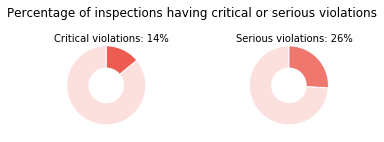

In [92]:
# Plot proportion of critical and serious violations in inspections
fig = plt.figure()
plt.suptitle('Percentage of inspections having critical or serious violations');

startingRadius=1
# First donut plot - Plotting proportion of critical violations
ax1 = fig.add_subplot(221)
critical_violation_donut = [100-critical_violations_percentage, critical_violations_percentage]
ax1.text(0.13, startingRadius + 0.17, "Critical violations: "+str(critical_violations_percentage)+"%", 
         horizontalalignment='center', verticalalignment='center')
ax1.pie(critical_violation_donut, radius=startingRadius, startangle=90, colors=['#fce0de', '#ed5b51'],
            wedgeprops={"edgecolor": "white", 'linewidth': 1})
circle = plt.Circle(xy=(0, 0), radius=0.45, facecolor='white')
plt.gca().add_artist(circle)

# Second donut plot - Plotting proportion of serious violations
ax2 = fig.add_subplot(222)
ax2.text(0.13, startingRadius + 0.17, "Serious violations: "+str(serious_violations_percentage)+"%", 
         horizontalalignment='center', verticalalignment='center')
serious_violation_donut = [100-serious_violations_percentage, serious_violations_percentage]
ax2.pie(serious_violation_donut, radius=startingRadius, startangle=90, colors=['#fce0de', '#f0776e'],
            wedgeprops={"edgecolor": "white", 'linewidth': 1})
circle = plt.Circle(xy=(0, 0), radius=0.45, facecolor='white')
plt.gca().add_artist(circle)

plt.show()

Every 1 out of four inspections found at least one serious violation. Considering the fact that both critical and serious violations are considered harmful to humans' health, these persentages are really not naive!

## Research questions

Below we present data analysis for each of the research questions we defined. These analysis leads to initial answers to these questions, we also describe one question we decided to drop (see Question 5). At the end of data analysis for each research question, we briefly describe what will/can be done with regards to the posed question.

### Question 1
**What are the most common reasons for a restaurant not passing an inspection?**

In this first question we want to explore the most common violations in the inspections that ended in failure. We will use Violation Codes and categories that we previously defined, and then we will do an analysis of most common violations for different communities. As a reminder, because of violation's changes, we will have different analysis for before and after the change.

#### Generalized violations analysis

In [93]:
# Focus only on failed inspections
failed_inspections_before = inspections_before_change[inspections_before_change['Results'] == 'Fail']
failed_inspections_after = inspections_after_change[inspections_after_change['Results'] == 'Fail']

Apart from grouping violations in 5 categories, we also named all of the validations, both before and after change. This is going to help us in better visualization of the violations.

In [94]:
violations_before_change = pd.read_excel(os.path.join(data_folder,'violation_names_before_2018.xlsx'))
violations_before_change.head()

,Violation code,Violation name
0,1,Approved food sources (1)
1,2,Proper facilities temperature (2)
2,3,Proper storage temperature (3)
3,4,Controlled cross contamination (4)
4,5,Healthy personnel (5)


Since we want to focus on the most common reasons for failing an inspection, we want to count how many times each violation occured in inspections that ended in failure.

In [95]:
# Create list of all violation codes found during failed inspections
all_violations_before_change_list = failed_inspections_before['Violation Codes'].values.tolist()
all_violations_before_change_list = [item for sublist in all_violations_before_change_list for item in sublist]

# Count occurencies of each validation
from collections import Counter
counted_violations_before_change = Counter(all_violations_before_change_list)
counted_violations_before_change = pd.DataFrame.from_dict(counted_violations_before_change, orient='index').reset_index()

violations_before_change = violations_before_change.merge(counted_violations_before_change, left_on = 'Violation code', right_on ='index').sort_values(by=0,ascending = True).rename(columns={0:'# violated'}).drop(columns='index')
violations_before_change.head()

,Violation code,Violation name,# violated
14,15,No re-served food (15),1
22,23,Proper dishes cleaning (23),5
4,5,Healthy personnel (5),9
19,20,Proper garbage disposal - inside (20),43
16,17,Proper thawning (17),54


Apart from getting the number of violation, we will enrich this data frame with three additional columns: Violation Category, Critical Violation and Serious Violation. Violation Category will be one of the previously mentioned 5 categories that we created. Critical Violation and Serious Violation are boolean valued columns saying whether violation is critical or serious, respectively. As we explained, validation codes 1-14 are critical violations, and 15-29 are serious violations. Note that we won't be able to create those two columns for the violations after change.

In [96]:
# Function that returns violation category for violations before 1.7.2018.
def get_violation_category_before_change(violationCode):
    # Definiton of code mappings
    food_codes_before = [1, 3, 15, 16, 17, 30]
    facility_codes_before = [2, 7, 9, 11, 13, 18, 22, 23, 24, 25, 26, 29, 32, 35, 36, 37, 38, 40, 42, 43]
    sanitary_codes_before = [4, 8, 10, 12, 19, 20, 27, 31, 33, 34, 39, 41]
    staff_codes_before = [5, 6, 21, 44, 45]
    unknown_codes_before = [14, 28, 70]
    
    if (violationCode in food_codes_before):
        return 'Food related violations'
    if (violationCode in facility_codes_before):
        return 'Facility related violations'
    if (violationCode in sanitary_codes_before):
        return 'Sanitary related violations'
    if (violationCode in staff_codes_before):
        return 'Staff related violations'
    if (violationCode in unknown_codes_before):
        return 'Other'
    return None

In [97]:
# Create columns - Violation Category, Critical Violation & Serious Violation
violations_before_change['Violation Category'] = violations_before_change['Violation code'].apply(lambda x: get_violation_category_before_change(x))
violations_before_change['Critical Violation'] = violations_before_change['Violation code'].apply(lambda x: is_critical_violation_before_change([x]))
violations_before_change['Serious Violation'] = violations_before_change['Violation code'].apply(lambda x: is_serious_violation_before_change([x]))

violations_before_change = violations_before_change.sort_values('# violated', ascending= False)
violations_before_change.head()

,Violation code,Violation name,# violated,Violation Category,Critical Violation,Serious Violation
33,34,Proper floors maintenance (34),12399,Sanitary related violations,False,False
34,35,Walls and ceiling maintenace (35),11450,Facility related violations,False,False
32,33,Clean equipement (33),11316,Sanitary related violations,False,False
17,18,Areas protected from rodents or insects (18),10199,Facility related violations,False,True
31,32,Design and maintenance of food preparation sur...,10097,Facility related violations,False,False


Now that we prepared the data for the analysis, we first want to see which violations are the ones that are present in the biggest number of failed inspections. We will plot all the violations names and the corresponding number of violations made, as well as the category to which that violation belongs to.

In [98]:
# Visualising only 25 most frequent violations
top_violations_before_change = violations_before_change.iloc[:25, :].copy()

categories = ['Food related violations', 'Facility related violations','Sanitary related violations','Staff related violations','Other']

fig = go.Figure()

colorscale = [px.colors.sequential.Plasma[0],
              px.colors.sequential.Plasma[2],
              px.colors.sequential.Plasma[5],
              px.colors.sequential.Plasma[7],
              px.colors.sequential.Plasma[9]
              ]

for (category,color) in zip(categories,colorscale):
    fig.add_trace(go.Bar(x=top_violations_before_change[top_violations_before_change['Violation Category']==category]['# violated'],
                y=top_violations_before_change[top_violations_before_change['Violation Category']==category]['Violation name'],
                name=category,
                orientation='h',
                hovertemplate='%{y}<br>Number of violations: %{x}',
                # choose color palette
                marker_color=color
                ))
fig.update_layout(
    title={
        'text': "Number of violations for failed inspection result",
        #'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Violation name',
        titlefont_size=20,
        tickfont_size=12,
        dtick= 1,
        categoryorder="total ascending"
    ),
    xaxis_title="Number of violations",
    bargap=0.4,
    legend=dict(
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    template="plotly_white"
    #height = 1200,
    #width = 1200
)
plot_offline(fig,"violations_failed_before.html")

We have a winner! Among the failed inspections, **dirty floor was mentioned the most** as one of the violations. Two out of top three violations are related to cleaningness in the restaurant. Interestingly, many restaurants have problems with walls and ceiling constructions. Due to the fact that we created the categories by ourselves and that we are assigning each violation to strictly one category, there could be that some part of ceiling and wall problems is also due to dirtiness apart from construction. 

It seems that "most popular violations" are sanitary and facility related. What suprises is that, even though we are analysing restaurants, there is only one food related violation among the top 10 and it is on 10th place.

Looking at the top violations in failing, the inadequate floor or ceiling maitenance does not seem so severe. Let's now focus only on critical violations and see what is the most frequent critical violation.

In [99]:
# Visualize critical violations

critical_before_change = violations_before_change[violations_before_change['Critical Violation']]
fig = go.Figure()

for (category,color) in zip(categories,colorscale):
  fig.add_trace(go.Bar(x=critical_before_change[critical_before_change['Violation Category']==category]['# violated'],
                y=critical_before_change[critical_before_change['Violation Category']==category]['Violation name'],
                name=category,
                orientation='h',
                hovertemplate='%{y}<br>Number of violations: %{x}',
                # choose color palette
                marker_color=color
                ))
fig.update_layout(
    title="Number of critical violations for failed inspection result",
    xaxis_title="Number of violations",
    yaxis_title="Critical violation name",
    yaxis_dtick= 1,
    # bargap=0.1,
    yaxis_categoryorder = "total ascending",
    template="plotly_white"
)
plot_offline(fig,"critical_violations_before.html")

When looking at critical violations only, the top violation is related to **proper food storage temperature**. According to the full violation description, it means that potentially hazardous food meets temperature requirements during storage, preparation and service. On second and third place we have facility related violations, and then come the ones related to adequate cleaning of all necessary areas and equipement.

In [100]:
# Visualize serious violations

serious_before_change = violations_before_change[violations_before_change['Serious Violation']]
fig = go.Figure()

for (category,color) in zip(categories,colorscale):
  fig.add_trace(go.Bar(x=serious_before_change[serious_before_change['Violation Category']==category]['# violated'],
                y=serious_before_change[serious_before_change['Violation Category']==category]['Violation name'],
                name=category,
                orientation='h',
                hovertemplate='%{y}<br>Number of violations: %{x}',
                # choose color palette
                marker_color=color
                ))

fig.update_layout(
    title="Number of serious violations for failed inspection result",
    xaxis_title="Number of violations",
    yaxis_title="Serious violation name",
    yaxis_dtick= 1,
    bargap=0.2,
    yaxis_categoryorder = "total ascending",
    template="plotly_white"
)
plot_offline(fig,"serious_violations_before.html")

Among the serious violations, the big problem for restaurants is that they do not have adequate protection from entrance of rodents and insects in the building. Also, many restaurants do not manage to correct serious violations they made, which also brings up the possibility to think about the performance of restaurants on re-inspections, which we will discuss later.

Now, we will do the same analysis for the violations after the change on 1.7.2018.

In [101]:
violations_after_change = pd.read_excel(os.path.join(data_folder,'violation_names_after_2018.xlsx'))
violations_after_change.head()

,Violation code,Violation name
0,1,Presence of person in charge (1)
1,2,Food service sanitation certificate holder (2)
2,3,Adequate management (3)
3,5,Procedures for reacting to customer sickness (5)
4,6,"Proper eating, tasting, drinking or tobacco us..."


In [102]:
# Create list of all violation codes found during failed inspections
all_violations_after_change_list = failed_inspections_after['Violation Codes'].values.tolist()
all_violations_after_change_list = [item for sublist in all_violations_after_change_list for item in sublist]

# Count occurencies of each validation
counted_violations_after_change = Counter(all_violations_after_change_list)
counted_violations_after_change = pd.DataFrame.from_dict(counted_violations_after_change, orient='index').reset_index()

violations_after_change = violations_after_change.merge(counted_violations_after_change, left_on = 'Violation code', right_on ='index').sort_values(by=0,ascending = False).rename(columns={0:'# violated'}).drop(columns='index')
violations_after_change.head()

,Violation code,Violation name,# violated
46,55,Adequate physical facilities (55),1935
3,5,Procedures for reacting to customer sickness (5),1927
2,3,Adequate management (3),1891
49,58,Allergen training (58),1506
31,38,No rodents or insects (38),1387


In [103]:
# Function that returns violation category for violations before 1.7.2018.
def get_violation_category_after_change(violationCode):
    # Definiton of code mappings
    food_codes_after = [11, 12, 13, 14, 15, 17, 23, 26, 27, 28, 30, 31, 37, 39, 42]
    facility_codes_after = [10, 18, 19, 20, 21, 22, 33, 35, 36, 38, 41, 43, 44, 48, 50, 51, 53, 55, 56, 59, 60, 62]
    sanitary_codes_after = [2, 8, 16, 40, 45, 46, 47, 49, 52, 54]
    staff_codes_after = [1, 3, 7, 9, 25, 57, 58]
    unknown_codes_after = [4, 5, 6, 24, 29, 32, 61, 63]
    
    if (violationCode in food_codes_after):
        return 'Food related violations'
    if (violationCode in facility_codes_after):
        return 'Facility related violations'
    if (violationCode in sanitary_codes_after):
        return 'Sanitary related violations'
    if (violationCode in staff_codes_after):
        return 'Staff related violations'
    if (violationCode in unknown_codes_after):
        return 'Other'
    return None

In [104]:
# Create columns - Violation Category, Critical Violation & Serious Violation
violations_after_change['Violation Category'] = violations_after_change['Violation code'].apply(lambda x: get_violation_category_after_change(x))
violations_after_change.head()

,Violation code,Violation name,# violated,Violation Category
46,55,Adequate physical facilities (55),1935,Facility related violations
3,5,Procedures for reacting to customer sickness (5),1927,Other
2,3,Adequate management (3),1891,Staff related violations
49,58,Allergen training (58),1506,Staff related violations
31,38,No rodents or insects (38),1387,Facility related violations


In [105]:
# Visualising only 25 most frequent violations
top_violations_after_change = violations_after_change.iloc[0:25,:].copy()

categories = ['Food related violations', 'Facility related violations','Sanitary related violations','Staff related violations','Other']

fig = go.Figure()


colorscale = [px.colors.sequential.Plasma[0],
              px.colors.sequential.Plasma[2],
              px.colors.sequential.Plasma[5],
              px.colors.sequential.Plasma[7],
              px.colors.sequential.Plasma[9]
              ]
              
for (category,color) in zip(categories, colorscale):
    fig.add_trace(go.Bar(x=top_violations_after_change[top_violations_after_change['Violation Category']==category]['# violated'],
                y=top_violations_after_change[top_violations_after_change['Violation Category']==category]['Violation name'],
                name=category,
                orientation='h',
                hovertemplate='%{y}<br>Number of violations: %{x}',
                # marker=dict(
                # color=px.colors.sequential.Plasma),
                # marker={'colorscale': 'Plasma'}
                # choose color palette
                marker_color=color
                        )
                )
fig.update_layout(
    template='plotly_white',
    title={
        'text': "Number of violations for failed inspection result",
        #'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Violation name',
        titlefont_size=16,
        tickfont_size=12,
        dtick= 1,
        categoryorder="total ascending"
    ),
    xaxis_title="Number of violations",
    bargap=0.4
)
plot_offline(fig,"violations_after_change.html")

We already mentioned the big differences and stricter criteria after the change date. That can also be noticed in the violations that are made the most. Now for the first time we can see a big impact of **violations related to employees training**. Apparently, many restaurants did not have time do adjust properly to the new regulations and failed in the past year and a half due to inadequate management or lack of allergen training for the staff. Also, the City of Chicago requires defined procedures for many situations that can happen in a restaurant, and one that is the most problematic for restaurants to comply with is **reacting in case of customer sickness.** So be careful and remind yourself of your first aid knowledge, because the restaurant employees apparently cannot help you properly. Of course, when looking at these reasons, we have to take into account that these changed violation list is valid for less than 18 months, so there is smaller amount of inspections which can be analyzed. 

#### Visualize most common violations

Below we present the visualizations of the most common violations, both for our generalized categories and original violation codes before and after the change of violations. Following functions are used for aggregations and extracting most common violations per community.

In [106]:
# Get violation codes list for each neighbourhood (zip code)
def violation_codes_by(data, by_column, violation_column):
  return data.groupby(by=by_column)[violation_column].apply(merge_violation_codes)

# Find top most common violations in given violations list
def most_common_violations(violations, max_violation_code, top=1):
  counts, _ = violation_counts(violations, max_violation_code)
  return np.argsort(counts)[::-1][:top] + 1  # add one to convert to violation code from index

# Find top most common violations in each neighbourhood (zip code)
def most_common_violations_by(data, by_column, violation_column, max_violation_code, top=1):
  return violation_codes_by(data, by_column, violation_column).apply(most_common_violations, max_violation_code=max_violation_code, top=top)

# Merges all violation codes from the column into one flat array
def merge_violation_codes(violation_series):
  return [code for inspection_violation_codes in violation_series.values for code in inspection_violation_codes]

# Creates the histogram for violation codes
def violation_counts(violations, max_violation_code):
  counts, code_bins = np.histogram(violations, bins=np.arange(1, max_violation_code + 2))
  return counts, code_bins

# Creates violation codes distribution from the dataframe
def violations_distribution(df, violation_column='Violation Codes', max_violation_code=70):
  # https://stackoverflow.com/a/38258158
  all_codes = merge_violation_codes(df[violation_column])
  counts, code_bins = violation_counts(all_codes, max_violation_code)
  return code_bins[:-1], counts

In [107]:
# For each community get the most common violation regarding original violations and created categories as well as the change in violations
by = 'Community'
most_common_violations_by_community_before_change = most_common_violations_by(inspections_before_change, by, 'Violation Codes', 70, top=1)
most_common_violations_by_community_after_change = most_common_violations_by(inspections_after_change, by, 'Violation Codes', 63, top=1)
most_common_generalized_violations_by_community = most_common_violations_by(inspections, by, 'Violation Codes Generalized', 5, top=1)

In [108]:
# Comine most common violations into one dataframe
most_common = pd.DataFrame(most_common_generalized_violations_by_community) \
    .rename(columns={'Violation Codes Generalized': 'general_most_common'}) \
    .merge(most_common_violations_by_community_before_change, left_index=True, right_index=True) \
    .rename(columns={'Violation Codes': 'before_most_common'}) \
    .merge(most_common_violations_by_community_after_change, left_index=True, right_index=True) \
    .rename(columns={'Violation Codes': 'after_most_common'}) \
    .reset_index()

In [109]:
# Transform most common general violation to value from list
most_common = most_common.explode('general_most_common')
most_common['community_name'] = most_common['Community'] # for plotting purposes

In [110]:
# Transform violation codes into names
def transform_violation_codes_into_names(violation_codes, names_mapping_df):
    names_array = [names_mapping_df[names_mapping_df['Violation code'] == code]['Violation name'].values for code in violation_codes]
    if len(names_array) > 0:
        return ', '.join([names[0] for names in names_array])
    else:
        return 'None'

most_common['before_most_common_names'] = most_common['before_most_common'].apply(transform_violation_codes_into_names, names_mapping_df=violations_before_change)
most_common['after_most_common_names'] = most_common['after_most_common'].apply(transform_violation_codes_into_names, names_mapping_df=violations_after_change)

In [111]:
# Create separate dataframes with limitted columns for ploting on maps
most_common_before = most_common.copy().drop(columns=['general_most_common', 'after_most_common', 'after_most_common_names']).explode('before_most_common')
most_common_after = most_common.copy().drop(columns=['general_most_common', 'before_most_common', 'before_most_common_names']).explode('after_most_common')
most_common.drop(columns=['before_most_common', 'after_most_common'], inplace=True)

# Reordering columns for plotting purposes (variables interpolation in template)
most_common = most_common[['Community', 'general_most_common', 'community_name', 'before_most_common_names', 'after_most_common_names']]

In [112]:
template = '<b>{}</b><br><b>Before 1/07/2018:</b> {}<br><b>After 1/07/2018:</b> {}'

In [113]:
figure = plot_map('Most common violations for Chicago communities', 
  geodata_path=os.path.join(data_folder, 'chicago-community-boundaries.json'), 
  dataframe=most_common, 
  key_property='community', key_column='Community', value_column='general_most_common',
  template=template,
  mapbox_access_token=MAPBOX_ACCESS_TOKEN,
  options={}
)
#figure.show()
plot_offline(figure,"common_violations_community.html")

The above plot shows that for all of the communities (apart from only the one that is not included in our geojson file for which the data is not displayed) the most common violation belonged to the "Facility related" violations. Hovering over the cells one can also inspect the most common original violation for a particular community before and after the change of violations.

Below we do separte plots for most common violations before and after the change of violations.

**Most common violations per neighborhood visualization (before 1/07/2018)**

In [114]:
# https://community.plot.ly/t/colors-for-discrete-ranges-in-heatmaps/7780
# Creates a colorscale with discrete steps for plotting given start and end rgb tuples and number of discrete values
def make_discrete_colorscale(start, end, n_categories):
    rs, gs, bs = start
    re, ge, be = end
    r, g, b = (re - rs)/(n_categories - 1), (ge - gs)/(n_categories - 1), (be - bs)/(n_categories - 1)
    colors = []
    for cat in range(n_categories):
        for i in range(2):
            colors.append([(cat + i) / n_categories, f'rgb({rs + cat*r}, {gs + cat*g}, {bs + cat*b})'])
    return colors

# Map violation codes to ordered values starting from 0
def map_violations_to_discrete_ordered_values(dataframe, mapped_column):
    original_values = list(dataframe[mapped_column].unique())
    mapped_to = list(range(len(original_values)))
    mapping = dict(zip(original_values, mapped_to))  # https://stackoverflow.com/a/209854
    dataframe[mapped_column] = dataframe[mapped_column].map(mapping)

In [115]:
map_violations_to_discrete_ordered_values(most_common_before, 'before_most_common')

# Plot the map
n_categories = len(most_common_before['before_most_common'])
template = '<b>{}</b><br>{}'
figure = plot_map('Most common violations for Chicago communities before 1/07/2018', 
  geodata_path=os.path.join(data_folder, 'chicago-community-boundaries.json'), 
  dataframe=most_common_before, 
  key_property='community', key_column='Community', value_column='before_most_common',
  template=template,
  mapbox_access_token=MAPBOX_ACCESS_TOKEN,
  options={
      'colorscale': make_discrete_colorscale((200, 200, 255), (0, 0, 255), n_categories),
      'showscale': False
})
#figure.show()
plot_offline(figure,"common_violations_community_before.html")

On the plot above one can identify, that most of the communities in Chicago have "Proper floor maintenance" as the most common violation. There is also a region of 7 communities in the soth-west part of Chicago for which "Clear equipment" was the most predominant violation in inspections.

**Most common violations per neighborhood visualization (after 1/07/2018)**

In [116]:
map_violations_to_discrete_ordered_values(most_common_after, 'after_most_common')

# Plot the map
n_categories = len(most_common_after['after_most_common'])
template = '<b>{}</b><br>{}'
figure = plot_map('Most common violations for Chicago communities after 1/07/2018', 
  geodata_path=os.path.join(data_folder, 'chicago-community-boundaries.json'), 
  dataframe=most_common_after, 
  key_property='community', key_column='Community', value_column='after_most_common',
  template=template,
  mapbox_access_token=MAPBOX_ACCESS_TOKEN,
  options={
      'colorscale': make_discrete_colorscale((200, 200, 255), (0, 0, 255), n_categories),
      'showscale': False
})
#figure.show()
plot_offline(figure,"common_violations_community_after.html")

After the change of violations there are a lot of communities with "Procedures for reacting to customer sickness" as the predominant violated cirterion. There is also a big region of communities in the middle and south bay side area with "Adequate management" violation as the most common one. This violation relates to hierarchy and reporting among the personell of the restaurants.



### Question 2
**Are there "safe to eat" areas or "dangerous to eat" areas in Chicago?**

We decided to explore safety of the community areas using following criteria:

1. **Percentage of inspections in which there were observed critical violations** : We consider areas in which restaurants make more critical violations as more dangerous.
2. **Percentage of failed inspections**: Naturally, if there are more failures, the area is more dangerous.
3. **Percentage of failed re-inspections**: If the restaurants do not correct their own mistakes, that is deffinitely not a safe place to eat
4. **Number of inspections of type Complaint or Suspected Food Poisoning**: These inspections imply that users haven't been satisfied with the conditions in the restaurants.
5. **Hand-crafted safety score**: This score should take into account all the results of inspections in that area, giving different weight to each Result - failures will decrease the score, passes with conditions increase, but not as much as clear pass etc.



First four criteria we want to explore both by districts and by community areas. Therefore we first prepare dataframes with all necessary information for the analysis.

In [117]:
# Function that creates dataframe with all necessary columns for safe-danger analysis, grouping by District or Community Area
def create_df_for_group_analysis(groupingColumn):
    group = inspections.copy().groupby(groupingColumn)

    # Column for total number of inspections
    df = group['Inspection ID'].count().rename('Total inspections').to_frame()

    # Column for number of inspections with critical violations
    df['# ins with critical violation'] = group.apply(lambda x: x[x['Critical Violation Noticed']]['Inspection ID'].count())

    # Column for number of failed inspections
    df['Failed inspections'] = group['Results'].apply(lambda x: (x=='Fail').sum())

    # Column for number of failed re-inspections
    re_inspections = inspections[inspections['Re-inspection']].copy()
    df['Total re-inspections'] = re_inspections.groupby(groupingColumn).count()['Inspection ID']
    df['Failed re-inspections']= re_inspections.groupby(groupingColumn)['Results'].apply(lambda x: (x=='Fail').sum())

    # Column for number of complaint/suspected food poisoning inspections
    complaint_inspections  = inspections[(inspections['Inspection Type']=='Complaint') | (inspections['Inspection Type']=='Suspected Food Poisoning')].copy()
    df['Complaint/SFP inspections'] = complaint_inspections.groupby(groupingColumn)['Inspection ID'].count()

    # Column for number of restaurants
    df['# restaurants'] = group['License #'].apply(set).apply(len)
    df.reset_index(level=0,inplace=True)
    return df

In [118]:
district_metrics = create_df_for_group_analysis('District')
community_metrics = create_df_for_group_analysis('Community')

In [119]:
district_metrics.isna().any()

District                         False
Total inspections                False
# ins with critical violation    False
Failed inspections               False
Total re-inspections             False
Failed re-inspections            False
Complaint/SFP inspections        False
# restaurants                    False
dtype: bool

In [120]:
community_metrics.isna().any()

Community                        False
Total inspections                False
# ins with critical violation    False
Failed inspections               False
Total re-inspections             False
Failed re-inspections            False
Complaint/SFP inspections         True
# restaurants                    False
dtype: bool

In [121]:
# Check missing values
community_metrics[community_metrics['Complaint/SFP inspections'].isna()]

,Community,Total inspections,# ins with critical violation,Failed inspections,Total re-inspections,Failed re-inspections,Complaint/SFP inspections,# restaurants
55,OAKLAND,14,3,5,5,2,NaN,6


In [122]:
# Check if there were Complaints or Suspected Food Poisonings in OAKLAND
inspections[(((inspections['Inspection Type']=='Complaint') | (inspections['Inspection Type']=='Suspected Food Poisoning'))&(inspections['Community']=='OAKLAND'))]

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Latitude,Longitude,Location,Re-inspection,Community,District,Violation Codes,Violation Codes Generalized,Critical Violation Noticed,Serious Violation Noticed


In [123]:
# Since there were no complaints, fill with 0
community_metrics['Complaint/SFP inspections'] = community_metrics['Complaint/SFP inspections'].fillna(0)

In [124]:
community_metrics.isna().any()

Community                        False
Total inspections                False
# ins with critical violation    False
Failed inspections               False
Total re-inspections             False
Failed re-inspections            False
Complaint/SFP inspections        False
# restaurants                    False
dtype: bool

In [125]:
# Function that enriches dataframe with parameters we want to analyze
def compute_parameters_for_group_analysis(df):

    # Column for percentage of inspections with critical violations
    df['% Critical'] = df['# ins with critical violation']/df['Total inspections']*100
    
    # Column for percentage of failed inspections
    df['% Failed'] = df['Failed inspections']/df['Total inspections']*100
    
    # Column for percentage of failed re-inspections
    df['% Re-Failed'] = df['Failed re-inspections']/df['Total re-inspections']*100
    
    # Column for percentage of failed re-inspections
    df['Average complaints/SFP'] = df['Complaint/SFP inspections']/df['# restaurants']
    
    return df

In [126]:
district_metrics = compute_parameters_for_group_analysis(district_metrics)
district_metrics.head()

,District,Total inspections,# ins with critical violation,Failed inspections,Total re-inspections,Failed re-inspections,Complaint/SFP inspections,# restaurants,% Critical,% Failed,% Re-Failed,Average complaints/SFP
0,Central,25194,3729,3842,4068,228,4386,4053,14.801143,15.249663,5.604720,1.082161
1,Far North Side,21943,3384,4426,4516,303,3595,3021,15.421775,20.170442,6.709477,1.190003
2,Far South Side,4912,684,974,1011,79,1790,743,13.925081,19.828990,7.814045,2.409152
3,Far Southwest Side,4352,503,788,765,47,1207,645,11.557904,18.106618,6.143791,1.871318
4,North Side,21077,3030,4036,4128,282,3398,3332,14.375860,19.148835,6.831395,1.019808


In [127]:
community_metrics = compute_parameters_for_group_analysis(community_metrics)
community_metrics.head()

,Community,Total inspections,# ins with critical violation,Failed inspections,Total re-inspections,Failed re-inspections,Complaint/SFP inspections,# restaurants,% Critical,% Failed,% Re-Failed,Average complaints/SFP
0,ALBANY PARK,2274,305,485,493,44,313.0,367,13.412489,21.328056,8.924949,0.852861
1,ARCHER HEIGHTS,676,79,123,125,7,81.0,108,11.686391,18.195266,5.600000,0.750000
2,ARMOUR SQUARE,2050,361,500,506,53,521.0,284,17.609756,24.390244,10.474308,1.834507
3,ASHBURN,896,91,122,121,6,235.0,135,10.156250,13.616071,4.958678,1.740741
4,AUBURN GRESHAM,1086,140,245,235,21,381.0,170,12.891344,22.559853,8.936170,2.241176


In [128]:
# Function that plots map divided into districts of communities (grouped_by) by using value from value_column
def plot_by_criteria(grouped_by, df, key_column, value_column, chart_name, options):
    
    # Drop unused columns
    columns = df.columns.values
    used_columns = set([key_column, value_column])
    dropped_columns = [column for column in columns if column not in used_columns]
    dataframe = df.drop(columns=dropped_columns)
    
    # Duplicate key and value columns for plotting with interpolated variables on hover
    dataframe[grouped_by] = dataframe[key_column]
    dataframe['value'] = dataframe[value_column]

    # Plot the map
    geodata_filename = f'chicago-{grouped_by}-boundaries.json'  # TODO: maybe rename the communities file
    return plot_map(title=chart_name, geodata_path=os.path.join(data_folder, geodata_filename),
             dataframe=dataframe, key_property=grouped_by, key_column=key_column,
             value_column=value_column,
             template='<b>{}</b>: {}',
             mapbox_access_token=MAPBOX_ACCESS_TOKEN,
             options=options)

#### Analysis by critical violations

As we previously discussed, not all violations are the same, and the most severe ones are critical violations. Therefore, if there are many inspections in which they were discovered, the area is considered more dangerous.

In [129]:
options = {
    'colorscale': 'Reds',
    'colorbar': {
        'title': 'Percentage',
        'ticksuffix': '%'
    }
}
figure = plot_by_criteria('district', district_metrics, 'District', '% Critical', 'Percentage of inspections with critical violations per district', options)
#figure.show()
plot_offline(figure,"sd_critical_district.html")

By looking at districts, we can see that South Side restaurants make the most critical violations, where Northwest side is the safest district considering this criteria.

In [130]:
figure = plot_by_criteria('community', community_metrics, 'Community', '% Critical', 'Percentage of inspections with critical violations per community', options)
#figure.show()
plot_offline(figure,"sd_critical_area.html")

If we take a closer look, Washington park restaurants on average make critical violation every fourth inspection. Oakland in South Side and Uptown in Far North Side are also highly ranked and can get a title of dangerous areas.

#### Analysis by failures

If the proportion of failures among total inspections is higher for some areas then for others, we consider them more dangerous areas.

In [131]:
figure = plot_by_criteria('district', district_metrics, 'District', '% Failed','Percentage of failed inspections per district', options)
#figure.show()
plot_offline(figure,"sd_failures_district.html")

South Side is really leading in number of failures. Almost every 4th inspection ended in failure! City centre seems to have the least problems with failures.

In [132]:
figure = plot_by_criteria('community', community_metrics, 'Community', '% Failed','Percentage of failed inspections per community area', options)
#figure.show()
plot_offline(figure,"sd_failures_area.html")

We can now clearly see that the source for such bad results of South Side are Oakland and Washington Park. Every third inspection in these community areas is a failed one. City center and Airports are pretty safe, as well as community areas in Far Southeast side.

#### Analysis by failed re-inspections

In [133]:
figure = plot_by_criteria('district', district_metrics, 'District', '% Re-Failed','Percentage of failed re-inspections per district', options)
#figure.show()
plot_offline(figure,"sd_reinspection_failed_district.html")

Again, worst performing district is South Side.

In [134]:
figure = plot_by_criteria('community', community_metrics, 'Community', '% Re-Failed', 'Percentage of failed re-inspections per community area', options)
#figure.show()
plot_offline(figure,"sd_reinspection_failed_district.html")

With 40% of failed-reinspections, Oakland deffinitely deserves to be avoided when choosing restaurants.

#### Analysis by Complaints/Suspected Food Poisoning

In [135]:
options = {
    'colorscale': 'Reds',
    'colorbar': {
        'title': 'Avg. no. of complaints'
    }
}
figure = plot_by_criteria('district', district_metrics,'District', 'Average complaints/SFP',' Average number of complaint or suspected food poisioning inspections per restaurant per district', options)
#figure.show()
plot_offline(figure,"sd_complaint_district.html")

We can clearly see that South is deffinitely more problematic than North.

In [136]:
figure = plot_by_criteria('community', community_metrics, 'Community', 'Average complaints/SFP',' Average number of complaint or suspected food poisioning inspections per restaurant per community area', options)
#figure.show()
plot_offline(figure,"sd_complaint_community.html")

Chatham and Calumet Heights have on average around 3.5 complaints per restaurant. What is really interesting that Oakland, previously considered as food-dangerous area, didn't have any complaint inspection in the previous ten years!

#### Analysis by Safety Score

As a last criteria for measuring whether neighborhood is "safe to eat" or "dangerous to eat", we will take into account the aggregate results of inspections for the restaurants in that area.

In [137]:
# Get contigency table
inspections_scores_by_area = inspections.groupby(['Community','Results']).size().unstack('Results', fill_value=0)
inspections_scores_by_area.head()

Results,Business Not Located,Fail,No Entry,Not Ready,Out of Business,Pass,Pass w/ Conditions
Community,,,,,,,
ALBANY PARK,0,485,103,27,211,1128,320
ARCHER HEIGHTS,0,123,22,8,49,368,106
ARMOUR SQUARE,0,500,40,14,129,1079,288
ASHBURN,0,122,21,6,68,542,137
AUBURN GRESHAM,0,245,45,13,106,537,140


We decided to create a formula which will give the overall score for each neighborhood, taking into account the number of inspections per each category, as well as penalizing the negative results and awarding the positive ones. 
If the restaurant was suspended, which means Out of Business or Business Not Located (according to the docs), that gives -2 point. If the restaurant failed, it will be -1 points. If it passes with condition, the score is 0.5 points. If the restaurant passed clearly, it gives 1 point. We then divide that by the total amount of restaurants in the neighborhood.

In [138]:
# Function that gives the safety score for the neighborhood
def get_safety_score(df):
    score = (-2)*df['Business Not Located']+(-2)*df['Out of Business']+(-1)*df['Fail']+0.5*df['Pass w/ Conditions']+1*df['Pass'] 
    number_of_inspections = df.sum(axis=1)
    return round(score/number_of_inspections, 2)

In [139]:
# Add safety score to DF
inspections_scores_by_area['Safety score'] = pd.Series(get_safety_score(inspections_scores_by_area))
inspections_scores_by_area.sort_values('Safety score', ascending=False).head()

Results,Business Not Located,Fail,No Entry,Not Ready,Out of Business,Pass,Pass w/ Conditions,Safety score
Community,,,,,,,,
O'HARE INTERNATIONAL AIRPORT,0,355,11,29,101,1744,433,0.53
CLEARING,0,66,13,4,26,354,74,0.51
GARFIELD RIDGE,0,192,30,4,101,992,195,0.46
LOOP,2,1580,87,129,642,7002,1724,0.45
SOUTH DEERING,0,62,10,1,27,271,59,0.43


Now, we want to visualise the results in order to see if there is any pattern.

In [140]:
inspections_scores_by_area.reset_index(level=0,inplace=True)

In [141]:
# Visualise neighorhoods with respect to the Safety Score they got
colorscale1 = px.colors.sequential.YlOrRd
colorscale1.reverse()

options = {
    'colorscale': colorscale1,
    'colorbar': {
        'title': 'Safety score'
    }
}
figure = plot_by_criteria('community', inspections_scores_by_area, 'Community', 'Safety score', 'Safety scores by community areas', options)
#figure.show()
plot_offline(figure,"sd_safety_score_area.html")

According to the safety scores we calculated, it seems that the safest places to eat are the **the two Airports and the City Center.** That's right, you may need to pay extra, since those are central tourist points, but you can be quite sure that the restaurant you are eating is fulfulling the regulations. As you are going further from this places, the risk increases. 


### Question 3
**Checking restaurants history of inspections, how are restaurants or whole areas changing in their inspection scores? Can one see any patterns in improvements with respect to inspection results? Are there areas/restaurant chains/restaurant types that follow some trends?**

#### Evolution with respect to Inspection Results

For the analysis of the history of inspections, we will use only the three most frequent results: Pass, Pass w/ conditions and Fail.

As a first indicator of restaurant quality, we will use the number of safety violations per inspection.

In [142]:
inspections["nb_violations"] = inspections.apply(lambda row: len(row['Violation Codes']), axis=1)
inspections.sample(5)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Longitude,Location,Re-inspection,Community,District,Violation Codes,Violation Codes Generalized,Critical Violation Noticed,Serious Violation Noticed,nb_violations
10740,2244123,SUBWAY,SUBWAY,1679112,Restaurant,Risk 1 (High),8711 S ASHLAND AVE,Chicago,IL,60620,...,-87.662910,"{'longitude': '41.735408702583165', 'latitude'...",False,AUBURN GRESHAM,Far Southwest Side,"[2, 3, 5, 10, 54, 55, 58]","[3, 4, 5, 2, 3, 2, 4]",False,True,7
28842,2071559,DON FRESCO,DON FRESCO,2411114,Restaurant,Risk 1 (High),520 W HARRISON ST,Chicago,IL,60607,...,-87.640466,"{'longitude': '41.874504999844035', 'latitude'...",False,NEAR WEST SIDE,West Side,"[3, 38, 40, 19, 21]","[1, 2, 2, 3, 4]",True,True,5
71689,1482455,TOKYO MARINA,TOKYO MARINA,10611,Restaurant,Risk 1 (High),5058-5060 N CLARK ST,Chicago,IL,60640,...,-87.668333,"{'longitude': '41.97417662844776', 'latitude':...",False,UPTOWN,Far North Side,[],[],False,False,0
65125,1532645,VIA LIMA RESTAURANT,VIA LIMA RESTAURANT,2368585,Restaurant,Risk 1 (High),4024 N LINCOLN AVE,Chicago,IL,60618,...,-87.679457,"{'longitude': '41.95492303714853', 'latitude':...",False,NORTH CENTER,North Side,[32],[2],False,False,1
41707,1965861,Starbucks,STARBUCKS (T1/B CONCOURSE-BAGGAGE CLAIM),34229,Restaurant,Risk 2 (Medium),11601 W TOUHY AVE,Chicago,IL,60666,...,-87.914428,"{'longitude': '42.008536400868735', 'latitude'...",False,O'HARE INTERNATIONAL AIRPORT,Far North Side,"[33, 34]","[3, 3]",False,False,2


Let's compare the number of violations for inspections with results "Pass", "Pass w/ conditions" and "Fail" :

In [143]:
inspections[inspections.Results == "Pass"].nb_violations.describe()

count    70453.000000
mean         2.585113
std          2.056755
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         13.000000
Name: nb_violations, dtype: float64

In [144]:
inspections[inspections.Results == "Fail"].nb_violations.describe()

count    24375.000000
mean         5.957949
std          3.490894
min          0.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         25.000000
Name: nb_violations, dtype: float64

As expected, the average number of violations is higher for restaurants who failed their inspection. However, an important detail shouldn't be overlooked: quartiles show that some failing restaurants have less violations than passing ones. We will therefore consider two parameters to evaluate how much restaurants improve over time: the difference between the intial average number of violations and the same average number at the last inspection, and their inspection result (Pass, Pass w/ conditions and Fail). 

In [145]:
def nvdiff(group):
    tmp = group.sort_values(by="Inspection Date")
    return (tmp.iloc[-1].nb_violations-tmp.iloc[0].nb_violations)
violations_evo = inspections.groupby("License #").apply(nvdiff)
violations_evo = pd.DataFrame({'License #':violations_evo.index, 'Violations evolution':violations_evo.values})

In [146]:
violations_evo.sample(5)

,License #,Violations evolution
9650,2121141,-10
19389,2658051,0
14252,2397605,0
17637,2564899,7
9746,2125616,0


We can now compute the average evolution score per community area (which is the average of the difference between the number of violations at first and last inspections for all restaurants of a given area).

In [147]:
violations_evo_community = violations_evo.merge(inspections[['License #','Community']], on='License #', how='left')\
                         .groupby('Community')['Violations evolution'].mean()
violations_evo_community = pd.DataFrame({'Community': violations_evo_community.index, 'evolution': violations_evo_community.values})
violations_evo_community.sample(5)

,Community,evolution
11,BRIGHTON PARK,-2.205965
34,JEFFERSON PARK,0.354463
22,ENGLEWOOD,-1.766590
63,SOUTH LAWNDALE,-2.514224
46,NEAR NORTH SIDE,-0.506176


In [148]:
options = {
    'colorscale': 'Reds',
    'colorbar': {
        'title': 'Evolution score'
    }
}
figure = plot_by_criteria('community', violations_evo_community, 'Community', 'evolution', 'Violations evolution score by community', options)
#figure.show()
plot_offline(figure,"violations_evolution_community.html")

We can see that in most areas, restaurants manage to decrease their number of violations over time. But in a few areas, restaurants have increased their number of violations.

We can also visualize the number of restaurants who have improved, got worse or stagnated over time.

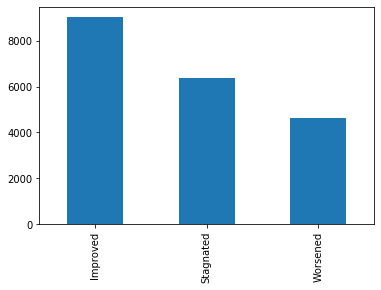

In [149]:
bins = [-np.inf,-0.1,0.1,np.inf]
cats = ["Improved", "Stagnated", "Worsened"]
pd.cut(violations_evo["Violations evolution"], bins, labels=cats).value_counts().plot.bar()

Most restaurants have improved or stagnated over time in their number of violations. The number of restaurants which got worse over time is smaller than the two other categories.

We will now compare the amount of restaurants who passed their most recent inspection in 2010 and 2018, per area. This will give us some insight in restaurant safety evolution over time.

In [150]:
# Number of inspections done in 2010
inspections[(inspections['Inspection Date'] >= '2010-01-01') & (inspections['Inspection Date'] < '2011-01-01')]['License #'].nunique()

6444

In [151]:
# Number of inspections done in 2018
inspections[(inspections['Inspection Date'] >= '2018-01-01') & (inspections['Inspection Date'] < '2019-01-01')]['License #'].nunique()

7409

In [152]:
# Selecting inspections done in 2010 and 2018
chicago_2010 = inspections[(inspections['Inspection Date'] >= '2010-01-01') & (inspections['Inspection Date'] < '2011-01-01')].copy()
chicago_2018 = inspections[(inspections['Inspection Date'] >= '2018-01-01') & (inspections['Inspection Date'] < '2019-01-01')].copy()
chicago_2010["Results"] = chicago_2010["Results"].apply(lambda x : x.startswith("Pass"))
chicago_2018["Results"] = chicago_2018["Results"].apply(lambda x : x.startswith("Pass"))

In [153]:
# Computing number of restaurants which passed their last inspection per community

pass_by_community2010 = chicago_2010.groupby(["License #", "Community"])\
                                .apply(lambda g : g.sort_values(by="Inspection Date").iloc[-1].Results)\
                                .groupby("Community")\
                                .sum()
pass_by_community2018 = chicago_2018.groupby(["License #", "Community"])\
                                .apply(lambda g : g.sort_values(by="Inspection Date").iloc[-1].Results)\
                                .groupby("Community")\
                                .sum()

In [154]:
# Converting counts to int
pass_by_community2010 = pd.DataFrame({"Community": pass_by_community2010.index, "Pass": pass_by_community2010.values})
pass_by_community2018 = pd.DataFrame({"Community": pass_by_community2018.index, "Pass": pass_by_community2018.values})
pass_by_community2010.Pass = pass_by_community2010.Pass.apply(lambda x : int(x))
pass_by_community2018.Pass = pass_by_community2018.Pass.apply(lambda x : int(x))

As not all areas have the same amount of restaurants, for each area we need to divide the number of restaurants passing inspections by the number of restaurants in the area to get a percentage.

In [155]:
community_count_2010 = chicago_2010.groupby("Community").apply(lambda g : g["License #"].nunique())
community_count_2018 = chicago_2018.groupby("Community").apply(lambda g : g["License #"].nunique())

In [156]:
community_count_2010 = pass_by_community2010.merge(pd.DataFrame({"Community": community_count_2010.index, "Count": community_count_2010.values}),on='Community', how='left')
community_count_2018 = pass_by_community2018.merge(pd.DataFrame({"Community": community_count_2018.index, "Count": community_count_2018.values}),on='Community', how='left')

In [157]:
# Computing pass percentages

community_count_2010.Pass = community_count_2010.apply(lambda row : row.Pass/row.Count, axis=1)
community_count_2018.Pass = community_count_2018.apply(lambda row : row.Pass/row.Count, axis=1)

In [158]:
community_count_2010 = community_count_2010.drop("Count",axis=1)
community_count_2018 = community_count_2018.drop("Count",axis=1)

In [159]:
# Convert from 0 to 1 floats to percentages and round it
def convert_to_rounded_percentages(dataframe, column):
    dataframe[column] = dataframe[column].apply(lambda x: round(100 * x, ndigits=1))

In [160]:
convert_to_rounded_percentages(community_count_2010, 'Pass')
convert_to_rounded_percentages(community_count_2018, 'Pass')

We can now plot the percentage of valid restaurants per area in 2010...

In [161]:
options = {
    'colorscale': [
        [0.0, 'rgb(255, 0, 0)'],
        [1.0, 'rgb(255, 255, 0)']
    ],
    'colorbar': {
        'title': 'Percentage',
        'ticksuffix': '%'
    }
}
figure = plot_by_criteria('community', community_count_2010, 'Community', 'Pass', 'Percentage of passing restaurants in 2010', options)
#figure.show()
plot_offline(figure,"percentage_passing_2010.html")

... and in 2018 :

In [162]:
figure = plot_by_criteria('community', community_count_2018, 'Community', 'Pass', 'Percentage of passing restaurants in 2018', options)
#figure.show()
plot_offline(figure,"percentage_passing_2018.html")

Overall, it seems that the percentage of restaurants passing inspections has decreased between 2010 and 2018 (which shows that the number of safety violations and and inspection results are not related, as we saw previously that most areas have decreased their number of violations over time). We can notice that the lowest percentage is lower in 2018 compared to 2010.

#### Evolution with respect to the risk level

We can now look into the evolution of risk levels over time. We define the risk level of a community area as the average of the risk levels of all restaurants in that area, as determined by their latest inspection. We will compare average risk levels between 2010 and 2018.

In [163]:
chicago_2018.Risk.unique()

array(['Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)', 'All'],
      dtype=object)

In [164]:
chicago_2018[chicago_2018.Risk == "All"]

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Longitude,Location,Re-inspection,Community,District,Violation Codes,Violation Codes Generalized,Critical Violation Noticed,Serious Violation Noticed,nb_violations
14699,2200988,111 COFFEE BAR,NaN,2608177,Restaurant,All,1419 W 111 TH ST,Chicago,IL,60643,...,-87.657782,"{'longitude': '41.692058710097896', 'latitude'...",False,MORGAN PARK,Far Southwest Side,[],[],False,False,0
21148,2145021,SAY GRACE RESTAURANT GROUP,LOVE TACO,2506479,Restaurant,All,109 E 51ST ST,Chicago,IL,60615,...,-87.622200,"{'longitude': '41.80189763712391', 'latitude':...",False,WASHINGTON PARK,South Side,[],[],False,False,0


We can see that two restaurants have the string "All" in their Risk column instead of a risk level. As these two restaurants have just been granted their license and have no inspection results, we will consider their risk level to be maximal (Risk 1 - High).

In [165]:
chicago_2018.replace({'Risk':{'All':'Risk 1 (High)'}},inplace=True)

In [166]:
chicago_2010 = chicago_2010[~chicago_2010.Risk.isna()]
chicago_2010.loc[:,'Risk'] = chicago_2010.Risk.apply(lambda r : int(r.split(" ")[1]))
chicago_2010.sample(5)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,...,Longitude,Location,Re-inspection,Community,District,Violation Codes,Violation Codes Generalized,Critical Violation Noticed,Serious Violation Noticed,nb_violations
122897,413930,MY LITTLE SPACE CYBER CAFE,MY LITTLE SPACE CYBER CAFE,2054682,Restaurant,1,2943 W IRVING PARK RD,Chicago,IL,60618,...,-87.702437,"{'longitude': '41.95384422496512', 'latitude':...",True,IRVING PARK,Northwest Side,[],[],False,False,0
127396,233768,IL VICINATO INC,IL VICINATO,6509,Restaurant,1,2435 S WESTERN AVE,Chicago,IL,60608,...,-87.685363,"{'longitude': '41.847385062646644', 'latitude'...",False,LOWER WEST SIDE,West Side,"[32, 33, 34, 35, 43, 16, 30]","[2, 3, 3, 2, 2, 1, 1]",False,True,7
122302,419429,Booil Restaurant,Booil Restaurant,1990863,Restaurant,1,3346 W Bryn Mawr AVE,Chicago,IL,60659,...,-87.713212,"{'longitude': '41.98312305188657', 'latitude':...",False,NORTH PARK,Far North Side,"[32, 33, 34, 35, 36, 38, 41]","[2, 3, 3, 2, 2, 2, 3]",False,False,7
125627,277142,CARNICERIA&FRUTERIA EL MITOTE,CARNICERIA & FRUTERIA EL MITOTE,49322,Restaurant,1,4459 W BELMONT AVE,Chicago,IL,60641,...,-87.739434,"{'longitude': '41.93881951468354', 'latitude':...",True,HERMOSA,Northwest Side,"[32, 33, 34, 35, 36, 30, 31]","[2, 3, 3, 2, 2, 1, 3]",False,False,7
129352,231231,WING CHAN,WING CHAN,6097,Restaurant,1,2157 S CHINA PL,Chicago,IL,60616,...,-87.635025,"{'longitude': '41.85363922646491', 'latitude':...",True,ARMOUR SQUARE,South Side,"[32, 33, 3, 36, 35, 38, 41]","[2, 3, 1, 2, 2, 2, 3]",True,False,7


In [167]:
chicago_2018 = chicago_2018[~chicago_2018.Risk.isna()]
chicago_2018.loc[:,'Risk'] = chicago_2018.Risk.apply(lambda r : int(r.split(" ")[1]))

In [168]:
# Computing average risk level per area

risk_by_com2010 = chicago_2010.groupby(["License #","Community"])\
                                .apply(lambda g : g.sort_values(by="Inspection Date").iloc[-1].Risk)\
                                .groupby("Community")\
                                .mean()
risk_by_com2018 = chicago_2018.groupby(["License #","Community"])\
                                .apply(lambda g : g.sort_values(by="Inspection Date").iloc[-1].Risk)\
                                .groupby("Community")\
                                .mean()

In [169]:
risk_by_com2010

Community
ALBANY PARK       1.203704
ARCHER HEIGHTS    1.076923
ARMOUR SQUARE     1.191781
ASHBURN           1.384615
AUBURN GRESHAM    1.416667
                    ...   
WEST LAWN         1.144928
WEST PULLMAN      1.437500
WEST RIDGE        1.088235
WEST TOWN         1.201863
WOODLAWN          1.611111
Length: 75, dtype: float64

In [170]:
risk_by_com2010 = pd.DataFrame({"Community":risk_by_com2010.index,"Mean risk": risk_by_com2010.values})
risk_by_com2018 = pd.DataFrame({"Community":risk_by_com2018.index,"Mean risk": risk_by_com2018.values})

We can now visualize the average risk level per area in 2010 :

In [171]:
options = {
    'colorscale': [
        [0.0, 'rgb(255, 0, 0)'],
        [1.0, 'rgb(255, 255, 0)']
    ],
    'colorbar': {
        'title': 'Risk level'
    }
}

figure = plot_by_criteria('community', risk_by_com2010, 'Community', 'Mean risk',\
                 'Mean risk level per area in 2010', options)
plot_offline(figure,"mean_risk_area_2010.html")

And in 2018 : 

In [172]:
options = {
    'colorscale': [
        [0.0, 'rgb(255, 0, 0)'],
        [1.0, 'rgb(255, 255, 0)']
    ],
    'colorbar': {
        'title': 'Risk level'
    }
}

figure = plot_by_criteria('community', risk_by_com2018, 'Community', 'Mean risk',\
                 'Mean risk level per area in 2018', options)
plot_offline(figure,"mean_risk_area_2018.html")

It seems that risk level averages have decreased, which means that restaurants are overall considered less safe.


#### Analysis on popular Restaurant chains

Let's now have at look at how the performance of famous restaurant chains changes over time.

In [173]:
chain_counts = inspections[["License #","AKA Name"]].drop_duplicates().groupby("AKA Name")\
                .agg('count').rename(columns={'License #':'count'}).sort_values(by="count",ascending=False)
chain_counts.head(30)

,count
AKA Name,
SUBWAY,336
DUNKIN DONUTS,172
MCDONALD'S,62
STARBUCKS,56
STARBUCKS COFFEE,55
BURGER KING,52
PIZZA HUT,46
TACO BELL,37
DUNKIN DONUTS/BASKIN ROBBINS,35


We will study some of the most popular restaurant chains in America :
* McDonalds
* Subway
* Dunkin Donuts
* KFC
* Burger King
* Pizza hut
* Taco bell
* Starbucks
  
Unfortunately, restaurant names in the dataset contain different spellings, and some also contain numbers. To identify restaurant chains, we need to find a substring for each chain name that is present only in the names of restaurants belonging to that chain.

In [174]:
# Filtering McDonalds

chicago_clean_names = inspections[~inspections["AKA Name"].isna()]
chicago_clean_names[(chicago_clean_names["AKA Name"].str.contains("Donald",case=False)) & ~
                    (chicago_clean_names["AKA Name"].str.contains("dogs",case=False))]["AKA Name"].unique()

array(["McDONALD'S", 'MCDONALDS RESTAURANT', "MCDONALD'S",
       'MCDONALDS #27672', 'MCDONALDï¿½S', 'MCDONALDS  (T3  K9)',
       "MCDONALD'S RESTAURANT  (T3 H9)", 'MCDONALDï¿½S 28128',
       'MCDONALDS', 'McDonalds', 'MCDONALDS #4655',
       "MCDONALD'S  (T3 HK FOOD COURT)", 'Mc DONALDS', "MCDONALD'S #490",
       'MCDONALD?S 28128', 'MC DONALDS', "MC DONALD'S",
       "McDONALD'S  (T2  E/F)", "Mc DONALD'S  (T3  L4)",
       "McDONALD'S  (T1  B11)", 'McDONALDS (T1 C10)', "MCDONALD'S #20104",
       "MCDONALD'S RESTAURANTS", 'MCDONALD?S', "McDONALD'S  (T5 ARRIVAL)",
       "MCDONALD'S RESTAURANT", "McDonald's Restaurant", 'McDONALDS',
       "McDonald's", "MCDONALD'S #5813", "MC DONALD'S RESTAURANT",
       "MC DONALD' S  # 6888", 'Mc DONALDS # 25509',
       "MCDONALD'S - McCAFE'", 'MC DONALDS-MCCORMICK PLACE NORTH',
       "MCDONALD'S #26364", 'Mc DONALDS # 6771', "McDONALD'S STORE #4061",
       "MC DONALD' S # 22100", "MCDONALD'S EXPRESS",
       "MCDONALD'S REST. OF ILLINOIS, 

We can see that all McDonalds restaurants, despite different names, all contain "Donald" in their names; hence we will use "Donald" to identify McDonalds.

In [175]:
# Filtering Dunkin Donuts

chicago_clean_names[chicago_clean_names["AKA Name"].str.contains("dunkin donuts",case=False)]["AKA Name"].unique()

array(['DUNKIN DONUTS', 'DUNKIN DONUTS/BASKIN ROBBINS',
       'DUNKIN DONUTS / BASKIN ROBBINS', 'DUNKIN DONUTS-BASKIN ROBBINS',
       'GRAND CITGO/ MR. SUB / DUNKIN DONUTS',
       'DUNKIN DONUTS / BASKIN ROBINS',
       'HALSTED SHELL, DUNKIN DONUTS, MR SUB',
       "DUNKIN DONUTS BASKIN ROBBINS TOGO'S",
       'DUNKIN DONUTS/ BASKIN ROBBINS', 'Dunkin Donuts',
       'Dunkin Donuts Baskin Robbins', 'DUNKIN DONUTS & BASKIN ROBBINS',
       'DUNKIN DONUTS & BASKIN ROBINS', 'DUNKIN DONUTS (T3 HK FOODCOURT)',
       'DUNKIN DONUTS BASKIN ROBBINS', 'DUNKIN DONUTS / BASKIN & ROBBINS',
       'JETBOX WITH DUNKIN DONUTS', 'BASKIN ROBBINS/ DUNKIN DONUTS',
       'DUNKIN DONUTS AND BASKIN ROBBINS', 'SNAPPY, DUNKIN DONUTS, MOBIL',
       'Baskin Robbins/Dunkin Donuts', 'DUNKIN DONUTS /  BASKIN ROBBINS',
       'DUNKIN DONUTS/BASKIN  ROBBINS', 'DUNKIN DONUTS INC',
       'CITGO/DUNKIN DONUTS', 'DUNKIN DONUTS/BASKIN ROBINS',
       'DUNKIN DONUTS  BASKIN ROBBINS', 'DUNKIN DONUTS /  BASKIN ROBINS

In [176]:
# Filtering Subway

chicago_clean_names[chicago_clean_names["AKA Name"].str.contains("Subway",case=False)]["AKA Name"].unique()

array(['SUBWAY', 'Subway', 'BP/SUBWAY', 'SUBWAY RESTAURANT',
       'SUBWAY (T3 ROTUNDA)', 'SUBWAY SANDWICHES', 'Subway Sandwiches',
       'SUBWAY SANDWICHES & SALADS', 'SUBWAY SANDWICH', 'SHELL SUBWAY',
       'SUBWAY SANDWICH STORE', 'BP & SUBWAY', 'SUBWAY SANDWICH & SALAD',
       'SUBWAY 28330', 'BP GAS & SUBWAY', 'SUBWAY #3333',
       'ROAD RANGER/SUBWAY',
       'Snappy Convenience Center/Subway/Dunkin Donut', 'SUBWAY 48735',
       'SUBWAY 47512', 'SUBWAY #45927', 'SUBWAY 24028', 'LALO SUBWAY INC',
       'MADISON SUBWAY LLC', 'SUBWAY #267771', 'Lakeview Subway',
       'SUBWAY #25917', 'SUBWAY SANDWICHES & SALAD',
       'SUBWAY SANDWICH & SALADS', 'SUBWAY FULLERTON & ASHLAND',
       'SUBWAY #23340', 'SUBWAY # 23333', 'SUBWAY #42676',
       'SUBWAY #23983', 'SUBWAY 24454'], dtype=object)

In [177]:
# Filtering KFC

chicago_clean_names[chicago_clean_names["AKA Name"].str.contains("KFC",case=False) | \
                   chicago_clean_names["AKA Name"].str.contains("Kentucky",case=False)]["AKA Name"].unique()

array(['KFC/TACO BELL', 'KFC', 'KENTUCKY FRIED CHICKEN', 'KFC EXPRESS',
       'KENTUCKY FRIED CHICKEN/LONG JOHN SILVERS',
       'Kentucky Fried Chicken', 'KENTUCKY FRIED CHICKEN 521054',
       'KFC/Long John Silver', 'KENTUCKY FRIED CHICKEN 521041',
       'KENTUCKY FRIED CHICKEN 521040', 'KENTUCKY FRIED CHICKEN 521039',
       'KENTUCKY FRIED CHICKEN 521037', 'KENTUCKY FRIED CHICKEN 521043',
       'KENTUCKY FRIED CHICKEN 521049', 'KENTUCKY FRIED CHICKEN 521035',
       'KENTUCKY FRIED CHICKEN 521046', 'KENTUCKY FRIED CHICKEN 521038',
       'KENTUCKY FRIED CHICKEN 521036', 'KENTUCKY FRIED CHICKEN 521047',
       'KENTUCKY FRIED CHICKEN 521042', 'KENTUCKY FRIED CHICKEN 521048',
       'KENTUCKY FRIED CHICKEN 521052', 'KENTUCKY FRIED CHICKEN 521044',
       'KFC/PIZZAHUT EXPRESS', 'KENTUCKY FRIED CHICKEN 200-049',
       'KENTUCKY FRIED CHICKEN 200 106', 'KENTUCKY FRIED CHICKEN 200 122',
       'KFC/LONG JOHN SILVER'], dtype=object)

In [178]:
# Filtering Burger King

chicago_clean_names[(chicago_clean_names["AKA Name"].str.contains("burger king",case=False)) & ~
                    (chicago_clean_names["AKA Name"].str.contains("hamburger",case=False))]["AKA Name"].unique()

array(['BURGER KING #7623', 'BURGER KING #11967', 'BURGER KING',
       'BURGER KING #10366', 'BURGER KING #207', 'BURGER KING #17392',
       'BURGER KING #22995', 'BURGER KING #2654', 'BURGER KING #25272',
       'BURGER KING 19467', 'BURGER KING  #1512', 'BURGER KING#7112',
       'BURGER KING #', 'BURGER KING #7112', 'BURGER KING #1512',
       'BURGER KING #11297', 'BURGER KING #244', 'BURGER KING #7674',
       'BURGER KING #10345', 'BURGER KING #5986', 'BURGER KING #7268',
       'BURGER KING #5818', 'BURGER KING #181', 'BURGER KING #7288',
       'BURGER KING #16882', 'BURGER KING #1250', 'BURGER KING #1308',
       'Burger King', 'BURGER KING #5495', 'BURGER KING #1272',
       'BURGER KING #1232', 'BURGER KING # 10797', 'BURGER KING # 215',
       'BURGER KING # 3386', 'BURGER KING  #11297', 'BURGER KING #12371',
       'BURGER KING 16598', 'BURGER KING #1303', 'BURGER KING # 14476',
       'BURGER KING # 12663', 'BURGER KING #8312', 'BURGER KING # 6345',
       'BURGER KING 

In [179]:
# Filtering Pizza Hut

chicago_clean_names[chicago_clean_names["AKA Name"].str.contains("pizza hut",case=False)]["AKA Name"].unique()

array(['Pizza Hut', 'PIZZA HUT', 'TARGET/STARBUCKS/PIZZA HUT',
       'PIZZA HUT/WING STREET', 'PIZZA HUT RESTAURANT',
       'PIZZA HUT 317249', 'TARGET/PIZZA HUT/STARBUCKS',
       'PIZZA HUT #405192', 'PIZZA HUT 317253', 'PIZZA HUT EXPRESS',
       'PIZZA HUT #405039', 'PIZZA HUT #714363',
       'Pizza Hut Express-Goldcoast Dogs'], dtype=object)

In [180]:
# Filtering Taco Bell

chicago_clean_names[(chicago_clean_names["AKA Name"].str.contains("taco",case=False)) & (chicago_clean_names["AKA Name"].str.contains("bell",case=False))]["AKA Name"].unique()

array(['TACO BELL', 'KFC/TACO BELL', 'TACO BELL #2513',
       "TACO BELL & LONG JOHN SILVER'S", 'TACO BELL CANTINA',
       'TACO BELL 32575', 'TACO BELL 34921', 'TACO BELL #30407',
       'Taco Bell', 'TACO BELL_#4171', 'TACO BELL #15855',
       'TACO BELL #15875', 'TACO BELL #5751'], dtype=object)

In [181]:
# Filtering Starbucks

chicago_clean_names[chicago_clean_names["AKA Name"].str.contains("starbucks",case=False)]["AKA Name"].unique()

array(['STARBUCKS  (T1  C-07)', 'STARBUCKS', 'STARBUCKS RESERVE ROASTERY',
       'STARBUCKS COFFEE', 'STARBUCKS COFFEE #49695',
       'STARBUCKS COFFEE #57239', 'Starbucks Coffee#2229',
       'Starbucks Coffee #2428', 'STARBUCKS COFFEE #2565',
       'STARBUCKS COFFEE #2545', 'STARBUCKS COFFEE #9942',
       'TARGET/STARBUCKS/PIZZA HUT', 'STARBUCKS #2756',
       'STARBUCKS  (T1-C27)', 'STARBUCKS COFFEE #13439',
       'STARBUCKS COFFEE #2527', 'STARBUCKS COFFEE #228',
       'STARBUCKS COFFEE #2410', 'STARBUCKS (T3/BAGGAGE CLAIM)',
       'STARBUCKS (T3 K15 FOOD COURT)', 'STARBUCKS  (T3 H6)',
       'STARBUCKS   T3 H-13', 'STARBUCKS  T3 L20',
       'STARBUCKS COFFEE (T1-B5)', 'STARBUCKS COFFEE (T1-B14)',
       'STARBUCKS COFFEE#2261', 'STARBUCKS COFFEE #2949',
       'STARBUCKS (T2 LL ARRIVAL)', 'STARBUCKS COFFEE #11751',
       'STARBUCKS  (T3 H2)', 'STARBUCKS COFFEE #2334',
       'STARBUCKS (T1/B CONCOURSE-BAGGAGE CLAIM)',
       'STARBUCKS (MAIN FLOOR)', 'STARBUCKS (T2 MAIN)'

In [182]:
def avg_violations_chain(df) :
    return [df[df["Inspection Date"].dt.year == year][["License #","nb_violations"]]\
            .groupby("License #").agg("mean").mean() for year in range(2010,2020)]

In [183]:
mcdo = chicago_clean_names[(chicago_clean_names["AKA Name"].str.contains("Donald",case=False)) & ~
                    (chicago_clean_names["AKA Name"].str.contains("dogs",case=False))]
subway = chicago_clean_names[chicago_clean_names["AKA Name"].str.contains("Subway",case=False)]
ddonuts = chicago_clean_names[chicago_clean_names["AKA Name"].str.contains("dunkin donuts",case=False)]
kfc = chicago_clean_names[chicago_clean_names["AKA Name"].str.contains("KFC",case=False) | \
                   chicago_clean_names["AKA Name"].str.contains("Kentucky",case=False)]
burgerk = chicago_clean_names[(chicago_clean_names["AKA Name"].str.contains("burger king",case=False)) & ~
                    (chicago_clean_names["AKA Name"].str.contains("hamburger",case=False))]
pizza_hut = chicago_clean_names[chicago_clean_names["AKA Name"].str.contains("pizza hut",case=False)]
taco_bell = chicago_clean_names[(chicago_clean_names["AKA Name"].str.contains("taco",case=False)) & (chicago_clean_names["AKA Name"].str.contains("bell",case=False))]
starbucks = chicago_clean_names[chicago_clean_names["AKA Name"].str.contains("starbucks",case=False)]

In [184]:
chains_df = pd.DataFrame({"Chain":["McDonald's","Subway","Dunkin Donuts","KFC","Pizza Hut",\
                                  "Taco Bell","Starbucks"],"Year":[list(range(2010,2020)) for i in \
                           range(7)],"avg_violation":
                         [[y.values[0] for y in avg_violations_chain(x)] for x in [mcdo,subway,ddonuts,kfc,pizza_hut,taco_bell,\
                                                 starbucks]]})
chains_df = chains_df.set_index(['Chain']).apply(pd.Series.explode).reset_index()
chains_df = chains_df.rename(columns={"avg_violation":"Average number of violations"})

We can now plot the average number of violations per inspection, for each year, for the restaurant chains we selected :

In [185]:
import plotly.graph_objects as go

fig = go.Figure()
for chain in chains_df.Chain.unique() :
    fig.add_trace(go.Scatter(
        x = chains_df[chains_df.Chain == chain].Year,
        y = chains_df[chains_df.Chain == chain]["Average number of violations"],
        mode = 'lines+markers',
        name = chain,
        hovertemplate =
        f'<b>{chain}</b>' +
        '<br><i>Year</i>: %{x}'+
        '<br><b>Average number of violations</b>: %{y:.2f}<br>'
    ))
fig.update_layout(hovermode='x')
#fig.show()
plot_offline(fig,"average_violation.html")


The restaurant chains with the lowest average number of violations, are (in chronological order) Subway, Starbucks, Subway, Starbucks, Taco Bell, KFC then Taco Bell.
What about their average inspection passing rates ?



In [186]:
chains_pass_df = pd.DataFrame({"Chain":["McDonald's","Subway","Dunkin Donuts","KFC","Pizza Hut",\
                                  "Taco Bell","Starbucks"],"Inspection pass rate":
                          [(1-x[x.Results == "Fail"].shape[0]/x.shape[0]) for x in [mcdo,subway,ddonuts,kfc,pizza_hut,taco_bell,\
                                                 starbucks]]})
fig = px.bar(chains_pass_df,x="Chain",y="Inspection pass rate",color="Inspection pass rate")\
    .for_each_trace(lambda t: t.update(name=t.name.replace("Chain=","")))
#fig.show()
plot_offline(figure,"inspections_pass_rate.html")

The restaurant chain with the lowest passing rate is McDonald's, and the highest rate belongs to Starbucks.

### Question 4
**How is restaurant performance in terms of inpection results related to geodemographic charactestics of the area (e.g. Life Quality Index)?**

In [187]:
lqi_zipcode = pd.read_csv(os.path.join(data_folder, "lqi_indexes.csv"), index_col=False)
lqi_zipcode.head()

,Unnamed: 0,zip_code,life_quality_index
0,0,60603,90
1,1,60604,90
2,2,60610,90
3,3,60654,89
4,4,60605,89


In [188]:
# Cast Zip code values to string
lqi_zipcode.zip_code = lqi_zipcode.zip_code.apply(lambda x: str(x))

In [189]:
lqi_zipcode.nunique()

Unnamed: 0            58
zip_code              58
life_quality_index    26
dtype: int64

In [190]:
inspections.Zip.nunique()

59

There is one zip code missing in our life quality index, it corresponds to Chicago airport (which makes sense as the airport is not the area where people live). In our analysis we will therefore use it for all of the other neighborhoods.

In [191]:
# Drop column before plotting
lqi_zipcode.drop(columns='Unnamed: 0', inplace=True)

In [234]:
options = {
    'colorscale':'Plasma',
    'colorbar': {
        'title': 'LQI'
    }
}
figure = plot_by_criteria('zip', lqi_zipcode, 'zip_code', 'life_quality_index', 'Life Quality Index by neighborhood', options)
#figure.show()
plot_offline(figure,"life_quality_index.html")

Life quality index in Chicago is the highest in bay area and goes down as we move away, generally we can say that south part of the city has worse life quality than the north part.

This actually matches the insights we got when analysing safe and dangerous areas in Chicago. Although we had many criteria for assessing how safe or dangerous it is to eat out in a particular area, in most of them South performed worse than North.

### Question 5
**How are inspection results connected to customer reviews? Are the best scored restaurants the ones with the best inspection results as well? Which client-reported issues are also noticed by inspections? Which issues are only discovered by inspections?**

#### Getting the users' rating

We decided to use Google Places API to retrieve information about restaurant ratings. We queried API by DBA Name value and Longitude and Latitude of a restaurant. Sometimes however, API responses didn't match the area we were concerned about, meaning that they returned a restaurant with similar name but not in Chicago. Some restaurants couldn't be retrieved at all. To be sure we analyze API response correctly we start by checking if restuarants for which we have ratings are the same ones as we queried for. We perform it by checking names similarity and addresses.

`restaurants.csv` is a file which contains place_id (returned by Google API), restaurant name, address, zip code, latitude and longitude from Chicago Inspections dataset. We will use this csv to compare with what was retrieved from Google API.

In [193]:
google_places_path = os.path.join(data_folder, "google_places.csv")
restaurants_path = os.path.join(data_folder, "restaurants.csv")

In [194]:
google_places = pd.read_csv(google_places_path)
restaurants = pd.read_csv(restaurants_path)

In [195]:
google_places.head()

,place_id,place_name,rating,total_number_of_ratings,price_level,address,city,zip_code
0,ChIJleWegJHTD4gRsIMGm3IjUcM,yolk - test kitchen,4.4,180.0,2.0,1767 n milwaukee ave,chicago,60647
1,ChIJI1dehI0xDogRRkvKIpUspHM,las asadas restaurant,4.0,166.0,2.0,3834 w 47th st,chicago,60632-4136
2,ChIJBRuLGC_MD4gRfUVkzaQBIZk,mini palapita,4.3,342.0,1.0,4968 n elston ave,chicago,60630
3,ChIJ-auSyWItDogRQwUqcwljejE,crazy bird chicken,4.7,67.0,NaN,1160 w grand ave,chicago,60642-5837
4,ChIJIYRFg7IsDogRAW0zLguKL-A,redhead piano bar,4.2,989.0,2.0,16 w ontario st,chicago,60654


In [196]:
restaurants.head()

,place_id,place_name,latitude,longitude,address,zip_code
0,ChIJleWegJHTD4gRsIMGm3IjUcM,yolk test kitchen,41.913588,-87.682203,1767 n milwaukee ave,60647.0
1,ChIJI1dehI0xDogRRkvKIpUspHM,las asadas mexican grill,41.808025,-87.720037,3834 w 47th st,60632.0
2,ChIJBRuLGC_MD4gRfUVkzaQBIZk,la palapita,41.808025,-87.720037,3834 w 47th st,60632.0
3,ChIJ-auSyWItDogRQwUqcwljejE,crazy bird,41.891193,-87.657055,1160 w grand ave,60642.0
4,ChIJIYRFg7IsDogRAW0zLguKL-A,the redhead piano bar,41.893371,-87.628783,16-18 w ontario st,60654.0


Let's see if all restaurants we got from Google are the ones we asked for and are located in Chicago:

We noticed that address from Chicago database has whitespace at the end so we remove it from each row:

In [197]:
restaurants.address = restaurants.address.apply(str.strip)

In [198]:
print(f"Google places API returned {len(google_places)} restaurants")

Google places API returned 13006 restaurants


Check if all restaurants are in Chicago:

In [199]:
not_chicago_restaurants = google_places[~(google_places.city == "chicago")]
print(f"Number of restaurants with non-chicago city {len(not_chicago_restaurants)}")

Number of restaurants with non-chicago city 2053


In [200]:
not_chicago_restaurants.head(10)

,place_id,place_name,rating,total_number_of_ratings,price_level,address,city,zip_code
13,ChIJVwHOlyi0D4gRNjLVMUoK00A,romano's macaroni grill,3.7,860.0,2.0,chicago,60666,NaN
16,ChIJo_4DJAG3D4gRPsUur_-crLQ,mcdonald's,3.6,468.0,1.0,1101 e oakton st,des plaines,60018
24,ChIJQ0br6L-WD4gRxBPZES-H8io,dairy queen (treat),4.5,106.0,1.0,502 s milwaukee ave,libertyville,60048-2823
25,ChIJ8W5KpKj0WYgRXlQU3Lknu-c,liberty house coffee and café,4.7,234.0,2.0,221 s liberty st,asheville,28801-2334
38,ChIJo_4DJAG3D4gRPsUur_-crLQ,mcdonald's,3.6,468.0,1.0,1101 e oakton st,des plaines,60018
46,ChIJsd4Bvr6vD4gRczYyW5bI0os,big bowl schaumburg,4.3,1014.0,2.0,e higgins rd,schaumburg,60173
47,ChIJj6gbC42xD4gR9EHXFjqir1w,krispy kreme,4.5,1218.0,1.0,412 e devon ave,elk grove village,60007
74,ChIJqQyWfSa0D4gRN_IZ45o_HCE,argo tea,3.5,45.0,1.0,chicago,60666,NaN
87,ChIJdwM9Ir7ID4gR0qNqi9vN3LM,charcoal flame,4.5,212.0,NaN,6800 dempster street,morton grove,60053
94,ChIJs1HOuK4FBYgREBfd2sHyGwg,la terraza,4.6,77.0,NaN,11520 w bluemound rd # 2,wauwatosa,53226-4000


We can see that sometimes the zip code was returned as a city, Chicago zip codes start with 60 therefore those entries where city is equal to a number starting with 60 are probably in Chicago and their city name is in the address column

In [201]:
address_chicago_count = len(google_places[google_places.address == "chicago"])
print(f"Number of places with chicago as address and zip code in city column is {address_chicago_count}")

Number of places with chicago as address and zip code in city column is 163


In [202]:
google_places[google_places.city.str.startswith("60", na=False)]

,place_id,place_name,rating,total_number_of_ratings,price_level,address,city,zip_code
13,ChIJVwHOlyi0D4gRNjLVMUoK00A,romano's macaroni grill,3.7,860.0,2.0,chicago,60666,NaN
74,ChIJqQyWfSa0D4gRN_IZ45o_HCE,argo tea,3.5,45.0,1.0,chicago,60666,NaN
106,ChIJTxSyOsfSD4gRUy8JoHTgkVw,piece out,NaN,NaN,NaN,chicago,60622,NaN
183,ChIJIVrbHPjMD4gRQfUHdZXic5U,la estrella blanca,3.9,29.0,NaN,chicago,60641,NaN
278,ChIJM_1zjXe2D4gRDAmIxvGytuw,chili's grill & bar,3.2,913.0,2.0,chicago,60666,NaN
...,...,...,...,...,...,...,...,...
12644,ChIJq9zsX_TSD4gRrRW0u2HLN1E,sweet bean & more,5.0,2.0,NaN,chicago,60614,NaN
12699,ChIJj_2hl5DMD4gRNunA9w1SI1I,central starlite family restaurant,NaN,NaN,NaN,chicago,60639,NaN
12775,ChIJz5h8elIzDogRgDuu28QU6Ic,ruby's soul food,NaN,NaN,NaN,chicago,60651,NaN
12813,ChIJDcM0Ey4zDogR2rNIPGIV_gs,come & get it,NaN,NaN,NaN,chicago,60644,NaN


If zip code starts with 60 move it to zip code column

In [203]:
chicago_idx = google_places.city.str.startswith("60", na=False)
google_places.loc[chicago_idx, 'zip_code'] = google_places['city']

In [204]:
google_places[google_places.city.str.startswith("60", na=False)]

,place_id,place_name,rating,total_number_of_ratings,price_level,address,city,zip_code
13,ChIJVwHOlyi0D4gRNjLVMUoK00A,romano's macaroni grill,3.7,860.0,2.0,chicago,60666,60666
74,ChIJqQyWfSa0D4gRN_IZ45o_HCE,argo tea,3.5,45.0,1.0,chicago,60666,60666
106,ChIJTxSyOsfSD4gRUy8JoHTgkVw,piece out,NaN,NaN,NaN,chicago,60622,60622
183,ChIJIVrbHPjMD4gRQfUHdZXic5U,la estrella blanca,3.9,29.0,NaN,chicago,60641,60641
278,ChIJM_1zjXe2D4gRDAmIxvGytuw,chili's grill & bar,3.2,913.0,2.0,chicago,60666,60666
...,...,...,...,...,...,...,...,...
12644,ChIJq9zsX_TSD4gRrRW0u2HLN1E,sweet bean & more,5.0,2.0,NaN,chicago,60614,60614
12699,ChIJj_2hl5DMD4gRNunA9w1SI1I,central starlite family restaurant,NaN,NaN,NaN,chicago,60639,60639
12775,ChIJz5h8elIzDogRgDuu28QU6Ic,ruby's soul food,NaN,NaN,NaN,chicago,60651,60651
12813,ChIJDcM0Ey4zDogR2rNIPGIV_gs,come & get it,NaN,NaN,NaN,chicago,60644,60644


If address is Chicago move it to city column

In [205]:
address_idx = (google_places.address == "chicago")
google_places.loc[address_idx, "city"] = "chicago"
google_places.loc[address_idx, "address"] = np.nan

In [206]:
not_chicago_restaurants = google_places[~(google_places.city == "chicago")]
print(f"Number of restaurants with non-chicago city {len(not_chicago_restaurants)}")

Number of restaurants with non-chicago city 1890


We can see that sometimes there are still cities denoted with zip codes starting with 60, let's check city for those values

In [207]:
google_places[google_places.city.str.startswith("60", na=False)]

,place_id,place_name,rating,total_number_of_ratings,price_level,address,city,zip_code
2408,ChIJ6xFHBL6vD4gRchf5OrA9qUg,northwest transportation center,4.0,20.0,NaN,schaumburg,60173,60173
5469,ChIJsTHl8TevD4gRVlyTfs6j5Y0,nic's organic fast food,3.1,31.0,NaN,schaumburg,60173,60173
6613,ChIJzQ0X9bYzDogRHT07KfAcfNA,mc café,4.5,2.0,NaN,cicero,60804,60804
7438,ChIJT0JHiqUzDogRlqHkJuSCgrs,nueva vida,4.2,6.0,NaN,cicero,60804,60804
8272,ChIJt1juNU80DogRzGgeK6nsrs0,red robin gourmet burgers and brews,3.9,1032.0,2.0,north riverside,60546,60546
8551,ChIJo3gfbs66D4gRNGDpJP0lFEo,mr d's sports bar & grill,4.3,56.0,NaN,arlington heights,60005,60005
8572,ChIJR5CMqiGuD4gR3N5M6VH7ryE,vincenzo palmieri dpm,4.8,19.0,NaN,elk grove village,60007,60007
9575,ChIJQ-X4Dq4zDogR543sVOJGvsk,hibachi seafood buffet,3.4,8.0,NaN,cicero,60804,60804
9736,ChIJ7aMROx4FD4gRRAVVecrnbUY,fantasea destinations,NaN,NaN,NaN,elgin,60123,60123
9794,ChIJs-zK38JKDogROyQY0tbyclU,sharky's fish,4.5,2.0,NaN,bellwood,60104,60104


It turns out that entries as cicero, north riverside, schaumburg or elgin are within Chicago aglomeration they are smaller towns or districts.

In [208]:
google_places[(~(google_places.zip_code.str.startswith("60", na=False)) & (google_places.city != "chicago"))]

,place_id,place_name,rating,total_number_of_ratings,price_level,address,city,zip_code
25,ChIJ8W5KpKj0WYgRXlQU3Lknu-c,liberty house coffee and café,4.7,234.0,2.0,221 s liberty st,asheville,28801-2334
94,ChIJs1HOuK4FBYgREBfd2sHyGwg,la terraza,4.6,77.0,NaN,11520 w bluemound rd # 2,wauwatosa,53226-4000
163,ChIJFXchGjxt_oYR3OZ7Dv4sz3A,mi linda michoacana,4.5,240.0,NaN,2002 34th st,lubbock,79411-1832
174,ChIJ2TzjVki8QIYR8rBeeXUQuGA,doña chela restaurant,4.3,212.0,1.0,1112 76th st,houston,77012-1004
186,ChIJf4UCjadCGYgRPk63PEDsfwo,compass group usa inc,NaN,NaN,NaN,6477 syers rd,holton,49425-7508
...,...,...,...,...,...,...,...,...
12967,ChIJ8WUga24zXIgRrtJ5T0sC08M,mediterranean delight,4.8,237.0,1.0,160 bus terminal rd a,oak ridge,37830
12974,ChIJScl8s92LOIgRwRKOCn4btuI,couscous house,4.9,100.0,1.0,1611 morse rd,columbus,43229
12975,ChIJrUpLxVkDBYgR2GJViXvlxkY,champion chicken,3.5,391.0,1.0,8718 w lisbon ave,milwaukee,53222-2859
13001,ChIJIVSzGQ3nEYgR8nZhwaBQ9ZM,food king china buffet,3.6,224.0,1.0,214 w ridge rd,griffith,46319-1041


We have 1071 rows which correspond to restaurants in different places than Chicago area. They are of no use to us so we remove them.

In [209]:
google_places_cleaned = google_places[((google_places.zip_code.str.startswith("60", na=False)) | (google_places.city == "chicago"))]
google_places_cleaned.head()

,place_id,place_name,rating,total_number_of_ratings,price_level,address,city,zip_code
0,ChIJleWegJHTD4gRsIMGm3IjUcM,yolk - test kitchen,4.4,180.0,2.0,1767 n milwaukee ave,chicago,60647
1,ChIJI1dehI0xDogRRkvKIpUspHM,las asadas restaurant,4.0,166.0,2.0,3834 w 47th st,chicago,60632-4136
2,ChIJBRuLGC_MD4gRfUVkzaQBIZk,mini palapita,4.3,342.0,1.0,4968 n elston ave,chicago,60630
3,ChIJ-auSyWItDogRQwUqcwljejE,crazy bird chicken,4.7,67.0,NaN,1160 w grand ave,chicago,60642-5837
4,ChIJIYRFg7IsDogRAW0zLguKL-A,redhead piano bar,4.2,989.0,2.0,16 w ontario st,chicago,60654


We will remove any duplicating rows from both dataframes as sometimes Google API might have returned same place_id for two distinct restaurants

In [210]:
pd.set_option('mode.chained_assignment', None)
google_places_cleaned.drop_duplicates(inplace=True)
restaurants.drop_duplicates(inplace=True)

Now we want to compare addresses and names of restaurants. We will start with joining Google places API output dataframe with restaurants dataframe on place_id. We perform left join on `google_places_cleaned` as we are only interested in cases when we received a response from Google API.

In [211]:
merged = google_places_cleaned.merge(restaurants, on="place_id", how="left", suffixes=("_google", "_restaurants"))
len(merged)

12057

In [212]:
merged.head()

,place_id,place_name_google,rating,total_number_of_ratings,price_level,address_google,city,zip_code_google,place_name_restaurants,latitude,longitude,address_restaurants,zip_code_restaurants
0,ChIJleWegJHTD4gRsIMGm3IjUcM,yolk - test kitchen,4.4,180.0,2.0,1767 n milwaukee ave,chicago,60647,yolk test kitchen,41.913588,-87.682203,1767 n milwaukee ave,60647.0
1,ChIJI1dehI0xDogRRkvKIpUspHM,las asadas restaurant,4.0,166.0,2.0,3834 w 47th st,chicago,60632-4136,las asadas mexican grill,41.808025,-87.720037,3834 w 47th st,60632.0
2,ChIJI1dehI0xDogRRkvKIpUspHM,las asadas restaurant,4.0,166.0,2.0,3834 w 47th st,chicago,60632-4136,las asadas,41.808025,-87.720037,3834 w 47th st,60632.0
3,ChIJI1dehI0xDogRRkvKIpUspHM,las asadas restaurant,4.0,166.0,2.0,3834 w 47th st,chicago,60632-4136,las asadas mar y tierra,41.844356,-87.725205,4014 w 26th st,60623.0
4,ChIJBRuLGC_MD4gRfUVkzaQBIZk,mini palapita,4.3,342.0,1.0,4968 n elston ave,chicago,60630,la palapita,41.808025,-87.720037,3834 w 47th st,60632.0


Sometimes we got a response from Google but we didn't get a rating, we drop rows where we couldn't retrieve rating from Google API.


In [213]:
merged[merged.rating.isna()]

,place_id,place_name_google,rating,total_number_of_ratings,price_level,address_google,city,zip_code_google,place_name_restaurants,latitude,longitude,address_restaurants,zip_code_restaurants
88,ChIJAQDAYrUsDogRP4hNEthCzr4,11 dining,NaN,NaN,NaN,363 w erie st,chicago,60654,"11 dining, llc",41.871996,-87.639204,801 s canal st,60607.0
89,ChIJAQDAYrUsDogRP4hNEthCzr4,11 dining,NaN,NaN,NaN,363 w erie st,chicago,60654,"11 dining, llc",41.880705,-87.632476,50 s la salle st,60603.0
139,ChIJ_w7sVbHTD4gRYiLj4jA2o-Y,smokey's wing shack,NaN,NaN,NaN,2627 w division st,chicago,60622,smokey's wing shack,41.902849,-87.693068,2627 w division st,60622.0
149,ChIJdeaorlMtDogRgPr-G3W_Lho,rare form lounge,NaN,NaN,NaN,2251 w taylor st,chicago,60612,jerky jerk rare,41.868908,-87.683275,2251-2253 w taylor st,60612.0
154,ChIJTxSyOsfSD4gRUy8JoHTgkVw,piece out,NaN,NaN,NaN,NaN,chicago,60622,piece out,41.910400,-87.676011,1923 w north ave,60622.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12045,ChIJRZ0swUgtDogRwJgm1QMCTNI,cuddle cupcakes,NaN,NaN,NaN,324 n leavitt st,chicago,60612-1671,foiled cupcakes,41.887434,-87.681849,324 n leavitt st,60612.0
12047,ChIJB3LyNm4wDogRg_HvhImIlNQ,west 79th street,NaN,NaN,NaN,w 79th st,chicago,NaN,79th & state brown's,41.751010,-87.624401,7859 s state st,60619.0
12048,ChIJg6P9MrcoDogRqBlzVpWEURY,a prepared table catering,NaN,NaN,NaN,553 e 79th st,chicago,60619-3035,a prepared table catering,41.751084,-87.610391,553 e 79th st,60619.0
12054,ChIJ5fNghEVMDogR4UWYi3iHLPE,dip'n good dips,NaN,NaN,NaN,17 monterey ave,villa park,60181-2822,dip & flip,41.775224,-87.683682,6510 s western ave,60636.0


In [214]:
merged.dropna(subset=["rating"],axis=0, inplace=True)

To check if for sure we have correct entries we will compare zip codes. If no zip_code is available from restaurants then we will compare names. First step would be to check where `zip_code_restaurants` is NaN
and second would be to remove second zip code component from `zip_code_google`

In [215]:
merged[merged.zip_code_restaurants.isna()]

,place_id,place_name_google,rating,total_number_of_ratings,price_level,address_google,city,zip_code_google,place_name_restaurants,latitude,longitude,address_restaurants,zip_code_restaurants
941,ChIJq7u58SPTD4gRqV7j2UThRLM,coffee lab & roasters,4.9,40.0,NaN,2823 n lincoln ave,chicago,60657,s.g.a. coffee cafe,41.958548,-87.786919,4300 n narragansett,NaN
1315,ChIJo3LREajSD4gROdM5Sjl8pTg,casa central,3.5,31.0,NaN,1343 n california ave,chicago,60622-2803,casa central la posada,41.878100,NaN,,NaN
7644,ChIJBV-jIEvTD4gROrQeGm3dLt0,starbucks,4.0,275.0,2.0,750 n franklin st,chicago,60654,starbucks coffee,41.896318,-87.635840,750 n franklin st.,NaN
8756,ChIJV1gyFIErDogR4vUnQw74VN4,mccormick place,4.5,8493.0,NaN,2301 s king dr,chicago,60616,mccornick place,41.851047,-87.622093,2301 s indiana,NaN
10696,ChIJTwjQ-HssDogRz558Go2FZu8,burger king,3.4,731.0,1.0,2328 s michigan ave,chicago,60616,burger king,41.850454,-87.623891,2320-2322 s michigan ave,NaN
11062,ChIJYZbHo0zTD4gReP8dX6Qfaco,think simple,5.0,2.0,NaN,770 n lasalle dr,chicago,60610,think simple foods,41.896504,-87.632784,141 w chicago ave,NaN
11155,ChIJV1gyFIErDogR4vUnQw74VN4,mccormick place,4.5,8494.0,NaN,2301 s king dr,chicago,60616,mccornick place,41.851047,-87.622093,2301 s indiana,NaN


We have only a couple of rows where zip_code_restaurants is not available, we can review them manually. It turns out that we will have to remove row 941, 11062 and McCormick place which is not a restaurant but a business center in Chicago.

In [216]:
merged.drop(axis=0, index=[941, 11062, 11155, 8756], inplace=True)

Now we will remove second `zip_code_google` component

Filling nans with string value to remove second `zip_code_google` component

In [217]:
merged.zip_code_google.fillna("nan", inplace=True)

In [218]:
merged.zip_code_google.str.len().unique()

array([ 5, 10,  3], dtype=int64)

In [219]:
merged.zip_code_google = merged.zip_code_google.apply(lambda x: x[:5])

In [220]:
merged.zip_code_google = merged.zip_code_google.replace("nan", np.nan)

In [221]:
merged.zip_code_google = merged.zip_code_google.apply(float)

Now we will take only those entries where every place has a matching zip code

In [222]:
matching = merged[merged.zip_code_google == merged.zip_code_restaurants]

At last to be sure that we have rating corresponding to a correct place we will compare names using python difflib. From docs "ratio() returns a float in [0, 1], measuring the similarity of the sequences. As a rule of thumb, a ratio() value over 0.6 means the sequences are close matches". We will use this property to discard any rows where name similarity is lower than 0.6. This step is necessary as sometimes name from Chicago database doesn't exactly match a name returned by Google API for instance in Chicago database we have: "yolk - test kitchen" while Google's response name is "yolk test kitchen"

In [223]:
from difflib import SequenceMatcher

def get_similarity_score(restaurant_name, google_name):
    return SequenceMatcher(lambda x: x == " ",
                    restaurant_name,
                    google_name).ratio()

In [224]:
matching['name_similarity_score'] = matching.apply(lambda row: get_similarity_score(row["place_name_restaurants"], row["place_name_google"]), axis=1)

In [225]:
matching = matching[matching.name_similarity_score > 0.6]

As a last step we remove rows with duplicated place_id

In [226]:
matching = matching.drop_duplicates(subset=["place_id"])

In [227]:
len(matching)

5700

we have ratings for 5700 restaurants

We will transform matching dataframe to use it for further analysis, we will remove useless columns and save it to csv file

In [228]:
matching.drop(["name_similarity_score", "place_name_google", "price_level", "address_google", "zip_code_google", "city"], axis=1, inplace=True)

In [229]:
matching.rename(columns={"place_name_restaurants": "place_name", "address_restaurants": "address", "zip_code_restaurants": "zip_code"}, inplace=True)

#### Analysis of number of ratings available

In [230]:
matching.total_number_of_ratings.describe()

count     5700.000000
mean       325.868246
std        659.889210
min          1.000000
25%         45.000000
50%        148.500000
75%        357.000000
max      17040.000000
Name: total_number_of_ratings, dtype: float64

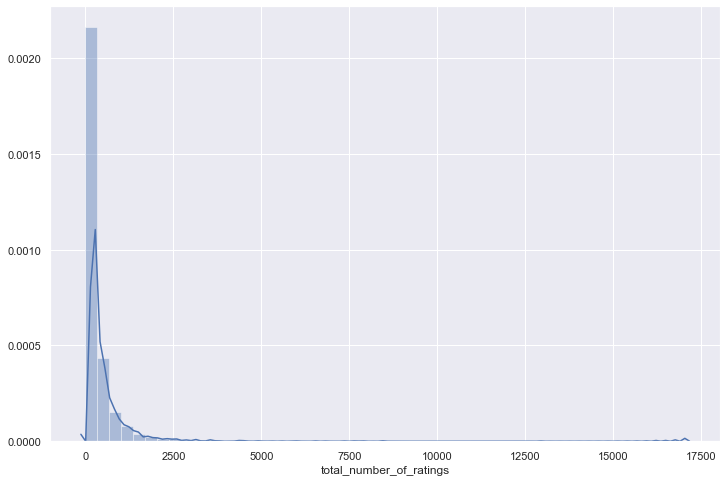

In [231]:
sns.set(rc={'figure.figsize':(12,8)})
sns.distplot(matching.total_number_of_ratings)

In [232]:
matching.total_number_of_ratings.mode()

0    1.0
dtype: float64

As number of ratings seem to follow a power law and most of restaurants have low number of ratings it would be very biased to compare them with restaurants that have tenths of thousands of ratings. Therefore we decide to drop this research question.

### Data story 

Check out our data story [here](https://jczestochowska.github.io/).